# Pipeline

imports

In [1]:
import json
import os
import numpy as np
import datetime
import random
import shutil
from scipy.stats import norm
from itertools import product 
from pathlib import Path

In [2]:
from prosimos import simulation_engine, simulation_properties_parser
from simod.event_log.event_log import EventLog
from simod.settings.simod_settings import SimodSettings
from simod.simod import Simod
from simod.simulation.prosimos import *


/opt/homebrew/Caskroom/miniconda/base/envs/robustness/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Pipeline

## 0. Input

In [3]:
# - event_log: historical process data
# - target_PPI: performance metric (e.g., cycle time)
# - PPI_target_range: acceptable range (e.g., [0, 5])
# - simulation_tool: engine for discrete-event simulation
# - changeable_parameters_list: list of parameters to vary
# # - simulation_model: built from event_log


# Inputs
# process_name = 'dummy_2tasks'
# process_name = 'LoanApp'
# process_name = 'LoanApp_SingleRole'
process_name = 'LoanApp_SingleRole_fixDuration'
# process_name = 'ten_activities'

target_ppi = 'cycle_time'
# target_ppi = 'idle_cycle_time'
ppi_range_factor = 0.3

cases_to_simulate = 1000
discover_bps_model = False
nr_simulations_per_scenario = 30

execute_strategy = ['grid_search', 'quadtree'] # 'diagonal_search', 'hill_climbing'

confidence = 0.90
dt = datetime.datetime(2025, 6, 23, 9, 0, tzinfo=datetime.timezone.utc)
simulation_tool = 'simod'

print_intermediate_results = True

# internal parameters
decimals = 2
# retain_simulation_data = False
simulation_results_confidence = True
in_out_criteria = "confidence"  # "mean" or "confidence"
simod_config_path = 'simulators/simod/resources/config/config_one-shot.yml'
                    



In [4]:
# Write inputs into 
base_path = os.path.join('data', process_name)

dt_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")

params = {
    'process_name': process_name,
    'base_path': base_path,
    'target_ppi': target_ppi,
    'ppi_range_factor': ppi_range_factor,
    'cases_to_simulate': cases_to_simulate,
    'starting_at':dt_str,
    'simulation_tool': simulation_tool,
    'nr_simulations_per_scenario': nr_simulations_per_scenario,
    'decimals': decimals,
    'simulation_results_confidence': simulation_results_confidence,
    'confidence': confidence,
    'in_out_criteria': in_out_criteria,
    'print_intermediate_results': print_intermediate_results,
    'execute_strategy': execute_strategy,
    'simod_config_path': simod_config_path
}

In [5]:


params['strategies'] = {
    'grid_search': {
        'granularity': 30,
        'input': 'original_input' 
    },
    'quadtree': {
        'max_depth': 7
    },
    'diagonal_search': {
        'stepsize_initial': 0.1,
        'step_max': 20,
        'adaptive_step': True,
        'strictness': 0.01
    },
    'hill_climbing': {
        'stepsize_initial': 0.1,
        'step_max': 20,
        # 'adaptive_step': True,
        'candidate_strategy': 'random_one',
        'walk_reps_max': 100
    }
}

In [6]:
# params[cases_to_simulate] = 100
# params['nr_simulations_per_scenario'] = 1
# params['confidence'] = confidence
# params['print_intermediate_results'] = False

### 0.5 Discovery

#### Utility functions

In [7]:
# create temporal simulation parameters file
def create_temp_json(input_path, output_path=None):

    if output_path == None:
        base, ext = os.path.splitext(input_path)
        if ext != '.json':
            raise ValueError('File extension must be .json')
        output_path = f'{base}_temp{ext}'

    # Step 1: Read the JSON
    with open(input_path, 'r') as infile:
        data = json.load(infile)

    # Step 2: Write a pretty-printed version
    with open(output_path, 'w') as outfile:
        json.dump(data, outfile, indent=4, sort_keys=True)

    return output_path

#### implement automatic calling of discovery

In [8]:
if discover_bps_model:

    # Specify the path to the simod directory
    simod_directory = os.path.join('simulators', 'simod')

    # output = Path(os.path.join(simod_directory, 'resources', 'output'))
    output = Path(os.path.join(params['base_path']))

    # TODO:
    # write funtction to set path to the genereic config file

    configuration_path = Path(os.path.join(simod_directory, 'resources', 'config', 'config_one-shot.yml' ))
    settings = SimodSettings.from_path(configuration_path)

    # Read and preprocess event log
    event_log = EventLog.from_path(
        log_ids=settings.common.log_ids,
        train_log_path=settings.common.train_log_path,
        # test_log_path=settings.common.test_log_path,
        preprocessing_settings=settings.preprocessing,
        need_test_partition=settings.common.perform_final_evaluation,
    )

    # Instantiate and run SIMOD
    simod = Simod(settings=settings, event_log=event_log, output_dir=output)
    simod.run()

In [9]:
# reading in of temp BPS_model json file

# dt = datetime.datetime(2025, 6, 23, 9, 0, tzinfo=datetime.timezone.utc)
# dt_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")

if discover_bps_model:
    bpmn_path = os.path.join(base_path, 'best_result', process_name + '.bpmn')
    json_path = os.path.join(base_path, 'best_result', process_name + '.json')


else:      
    bpmn_path = os.path.join(base_path, process_name + '.bpmn')
    json_path = os.path.join(base_path, process_name + '.json')


params['json_path'] = json_path
json_path_temp = create_temp_json(input_path=json_path, output_path=None)
params['bpmn_path'] = bpmn_path
params['json_path_temp'] = json_path_temp


##### BPMN plotting

In [10]:

# # Import necessary modules from pm4py
# from pm4py.objects.bpmn.importer import importer as bpmn_importer
# from pm4py.visualization.bpmn import visualizer as bpmn_visualizer
# import matplotlib.pyplot as plt

# # Specify the path to your BPMN file
# bpmn_path = params['bpmn_path']  # Path to the BPMN file

# # Import the BPMN model
# bpmn_model = bpmn_importer.apply(bpmn_path)

# # Visualize the BPMN model
# gviz = bpmn_visualizer.apply(bpmn_model)

# # Render the visualization
# bpmn_visualizer.view(gviz)

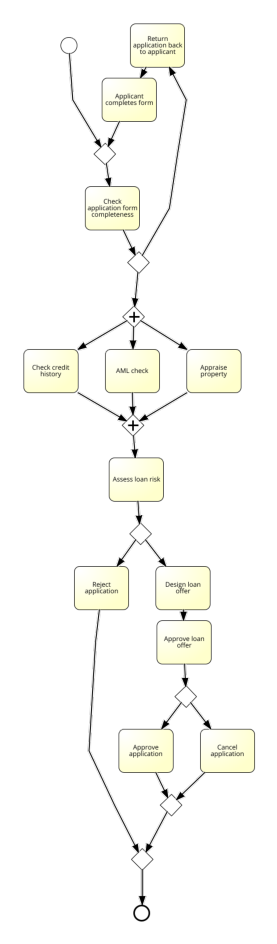

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specify the path to your PNG file
name = params['process_name']
image_path = os.path.join(params['base_path'],  f'{name}.png')

# Load and display the image
img = mpimg.imread(image_path)
fig = plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis('off')  # Turn off the axis
plt.show()

## 1.  Set up

### Helping functions

#### Run simulation

In [540]:
def get_simulation_stats(params):
    """
    Executes the simulation n times and returns the average value of the target PPI.

    Args:
        params (dict): Simulation parameters, including the number of simulations to run.

    Returns:
        Average value of the target PPI across all simulations or list of values if confidence intervals are needed.
    """
    nr_simulations = params.get('nr_simulations_per_scenario', 1)  # Default to 1 if not specified
    ppi_values = []

    for _ in range(nr_simulations):
        # Run the simulation
        (r, t) = simulation_engine.run_simulation(
            bpmn_path=params['bpmn_path'], 
            json_path=params['json_path_temp'],
            total_cases=params['cases_to_simulate'],
            starting_at=params['starting_at'],
            is_event_added_to_log=False,
            fixed_arrival_times=None,
        )

        # Retrieve the target PPI value
        value = getattr(getattr(r[0], params['target_ppi']), 'avg')
        ppi_values.append(value)

    if not params['simulation_results_confidence']:
        # Calculate and return the average of the PPI values
        ppi_values = sum(ppi_values) / len(ppi_values)

    return ppi_values

#### Getting / setting sim parameters

In [12]:
import yaml

def read_train_log_path(params):
    """
    Reads the YAML file specified in params['simod_config'] and extracts the 'train_log_path' 
    variable under the 'common' section.

    Args:
        params (dict): A dictionary containing the key 'simod_config' with the path to the YAML file.

    Returns:
        None
    """
    try:
        # Read the YAML file specified in params['simod_config']
        simod_config_path = params.get("simod_config_path")
        if not simod_config_path:
            print("Error: 'simod_config' key is missing in the params dictionary.")
            return
        
        with open(simod_config_path, "r") as file:
            config = yaml.safe_load(file)
        
        # Extract the 'train_log_path' under the 'common' section
        train_log_path = config.get("common", {}).get("train_log_path")
        if train_log_path:
            print(f"Train Log Path: {train_log_path}")
        else:
            print("Error: 'train_log_path' not found under the 'common' section in the YAML file.")
    
    except FileNotFoundError:
        print(f"Error: The file '{simod_config_path}' does not exist.")
    except yaml.YAMLError as e:
        print(f"Error: Failed to parse the YAML file. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [13]:
read_train_log_path(params)

Train Log Path: ../../../../data/ten_activities/ten_activities.csv


In [14]:
import yaml
from ruamel.yaml import YAML

def update_train_log_path(params):
    """
    Reads the YAML file specified in params['simod_config'], updates the 'train_log_path' parameter
    under the 'common' section with a new value based on params['process_name'], and writes the
    updated content back to the YAML file while preserving the layout.

    Args:
        params (dict): A dictionary containing:
            - 'simod_config': Path to the YAML file.
            - 'process_name': Name of the process to update the train_log_path with.

    Returns:
        None
    """
    try:
        # Ensure required keys exist in params
        simod_config_path = params.get("simod_config")
        process_name = params.get("process_name")
        if not simod_config_path or not process_name:
            print("Error: 'simod_config' or 'process_name' key is missing in the params dictionary.")
            return

        # Load the YAML file while preserving layout
        yaml = YAML()
        yaml.preserve_quotes = True  # Preserve quotes and formatting
        with open(simod_config_path, "r") as file:
            config = yaml.load(file)

        # Find and update the 'train_log_path' under the 'common' section
        train_log_path = config.get("common", {}).get("train_log_path")
        if train_log_path:
            # Replace the data folder and update the path
            updated_path = train_log_path.split("data/")[0] + f"data/{process_name}/{process_name}.csv"
            config["common"]["train_log_path"] = updated_path
            print(f"Updated train_log_path: {updated_path}")
        else:
            print("Error: 'train_log_path' not found under the 'common' section in the YAML file.")
            return

        # Write the updated YAML back to the file
        with open(simod_config_path, "w") as file:
            yaml.dump(config, file)
        print(f"Updated YAML file saved to: {simod_config_path}")

    except FileNotFoundError:
        print(f"Error: The file '{simod_config_path}' does not exist.")
    except yaml.YAMLError as e:
        print(f"Error: Failed to parse the YAML file. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

ModuleNotFoundError: No module named 'ruamel'

In [541]:
# get simulation parameters
# currently read json in 
def get_sim_params(json_path_temp):
    with open(json_path_temp, 'r') as infile:
        sim_params = json.load(infile)
    return sim_params

def set_sim_params(json_path_temp, sim_params):
    """
    Write updated simulation parameters back to the temporary JSON file.
    """
    with open(json_path_temp, 'w') as outfile:
        json.dump(sim_params, outfile, indent=4, sort_keys=True)


In [542]:


# change_param = 'arriaval_distr_mean'
# get_change_param_values(params_to_change, change_param, sim_params)

# def set_change_param_value(change_param, new_value, sim_params):
#     """
#     Update the value of a specified parameter in the simulation parameters dictionary.
#     """
#     if change_param == 'arriaval_distr_mean':
#         sim_params['arrival_time_distribution']['distribution_params'][0]['value'] = new_value
#     else:
#         raise ValueError(f"Unsupported parameter for setting: {change_param}")
#     return sim_params


def set_change_param_value(param_name, new_value, sim_params):
    """
    Updates a specific parameter in the simulation parameters, including resources.

    Args:
        param_name (str): The name of the parameter to update.
        new_value (float or int): The new value to set for the parameter.
        sim_params (dict): The simulation parameters JSON structure.

    Returns:
        dict: The updated simulation parameters.
    """
    if param_name == "arriaval_distr_mean":
        # Update the arrival time distribution mean
        if "arrival_time_distribution" in sim_params:
            sim_params["arrival_time_distribution"]["distribution_params"][0]["value"] = new_value
    elif param_name.startswith("resource_count_"):
        # Update resource-specific parameters
        resource_id = param_name.split("_")[-1]  # Extract the resource ID
        for resource_profile in sim_params.get("resource_profiles", []):
            if resource_profile["id"] == resource_id:
                for resource in resource_profile.get("resource_list", []):
                    resource["amount"] = new_value
                break
    # elif param_name.startswith("resource_"):
    #     # Update resource-specific parameters
    #     resource_id = param_name.split("_")[1]  # Extract the resource ID
    #     for resource_profile in sim_params.get("resource_profiles", []):
    #         if resource_profile["id"] == resource_id:
    #             for resource in resource_profile.get("resource_list", []):
    #                 resource["amount"] = new_value
    #             break

    # elif param_name == 'resource_count':
    #     sim_params['resource_profiles'][0]['resource_list'][0]['amount'] = new

    
    return sim_params

In [543]:
# change_param = 'arriaval_distr_mean'
# change_param = 'resource_count'
# get_change_param_values(params_to_change, change_param, sim_params)
# sim_params['resource_profiles']

In [544]:
def get_resource_profile_ids_and_amounts(resource_model):
    """
    Extracts resource profile IDs and their corresponding amounts from the resource model.

    Args:
        resource_model (dict): The resource model containing resource profiles.

    Returns:
        dict: A dictionary where keys are resource profile IDs and values are their amounts.
    """
    resource_profiles = resource_model.get("resource_profiles", [])
    resource_data = {}

    for profile in resource_profiles:
        profile_id = profile.get("id")
        resource_list = profile.get("resource_list", [])
        
        # Sum up the amounts for all resources in the resource list
        total_amount = sum(resource.get("amount", 0) for resource in resource_list)
        
        # Store the profile ID and total amount
        resource_data[profile_id] = total_amount

    return resource_data



In [545]:
def set_params_to_change(input_parameters, update_parameter, sim_params):
    '''
    Adjusts the input parameters dictionary to account for resource-specific parameters.    
    Args:
        input_parameters (dict): Original dictionary of parameters to change.
        update_parameter (str): The parameter being updated.
        sim_params (dict): The current simulation parameters.
    Returns:
        dict: Updated dictionary of parameters to change.
    '''

    params_to_change = input_parameters.copy()

    if update_parameter == 'resource_count':
        params_to_change = {k: v for k, v in input_parameters.items() if k != 'resource_count'}
        resource_data = get_resource_profile_ids_and_amounts(sim_params)
        for resource_id, amount in resource_data.items():
            param_key = f'resource_count_{resource_id}'
            params_to_change[param_key] = {
                'type': 'disc',
                'values': input_parameters['resource_count']['values']
            }

    return params_to_change



In [546]:
# get change_param_values 
def get_change_param_values(params_to_change, change_param, sim_params):
    if change_param == 'arriaval_distr_mean':
        change_param_val = sim_params['arrival_time_distribution']['distribution_params'][0]['value']

    # elif change_param == 'resource_count':
    #     change_param_val = sim_params['resource_profiles'][0]['resource_list'][0]['amount']
    elif change_param.startswith("resource_count_"):
        # Split of "resource_count_" from the beginning of the resource_id string
        resource_id = change_param[len("resource_count_"):]
        for resource_profile in sim_params.get("resource_profiles", []):
            if resource_profile["id"] == resource_id:
                for resource in resource_profile.get("resource_list", []):
                    change_param_val = resource["amount"]

    if change_param not in params_to_change.keys():
        raise ValueError(f"Unsupported parameter for change values: {change_param}")

    return change_param_val 

In [547]:
def get_start_param_settings(params_to_change, params):
    """ Retrieve the starting parameter settings from the simulation parameters.    
    Args:
        params_to_change (list): List of parameters to vary.
        params (dict): General parameters including json_path.
    Returns: 
        dict: A dictionary containing the starting parameter settings.
    """
    sim_params = get_sim_params(params['json_path'])
    start_param_settings = {}
    for param in params_to_change:
        start_param_settings[param] = get_change_param_values(params_to_change, change_param=param, sim_params=sim_params)
        
    return start_param_settings

#### Logging functions

In [548]:
# Logging function
def log_simulation(algorithm, params, param_values, target_ppi_list):
    """
    Logs the details of a simulation run.

    Args:
        algorithm (str): Name of the algorithm used.
        params (dict): Simulation parameters including target range and target PPI.
        param_values (dict): Dictionary of parameter values used in the simulation.
        target_ppi_list (list): List of target PPI values obtained from the simulation.
    Returns:
        None
    """
    global simulation_log

    target_ppi_val = np.mean(target_ppi_list)

    # Determine success status
    # status = "in" if params['target_range'][0] <= target_ppi_val <= params['target_range'][1] else "out"
    status = is_in_target_range(target_ppi_list, params, strictness=None)

    # Create a log entry
    log_entry = {
        "algorithm": algorithm,
        "simulation_id": len(simulation_log),
        "timestamp": datetime.datetime.utcnow().isoformat() + "Z",
        "target_range": params['target_range'],
        "status": status,
        "target_ppi": params['target_ppi'],
        "target_ppi_mean": target_ppi_val,
        "target_ppi_list": target_ppi_list,
        **param_values  # Dynamically add parameter values as columns
    }

    # Append the log entry to the simulation log
    simulation_log = pd.concat([simulation_log, pd.DataFrame([log_entry])], ignore_index=True)

def initialize_simulation_log(params_to_change):
    """
    Initializes the simulation log DataFrame with specified parameter names.

    Args:
        params_to_change (dict): Dictionary of parameters to change.
    Returns:
        pd.DataFrame: An empty DataFrame with the appropriate columns.
    """
    global simulation_log
    param_names = list(params_to_change.keys())
    columns = ['algorithm', 'simulation_id', 'timestamp', 'target_range', 'status', 'target_ppi', 'target_ppi_mean', 'target_ppi_list'] + param_names
    simulation_log = pd.DataFrame(columns=columns)

#### Simulation execution

In [549]:


def is_in_target_range(target_ppi_list, params, strictness=None, above_below=False):

    """
    Checks whether the target_ppi_list satisfies the in/out criteria for the target range.

    Args:
        target_ppi_list (list): A list of PPI values to evaluate.
        params (dict): A dictionary containing simulation parameters, including:
                       - "target_range": A tuple (min, max) defining the acceptable range.
                       - "confidence": Confidence level for normal distribution checks (e.g., 0.9).
        in_out_criteria (str): The criteria to check:
                               - "mean": Check if the mean of the list is within the target range.
                               - "confidence": Check if the specified confidence interval of the list
                                 lies within the target range.
        strictness (float): The strictness parameter for adjusting the target range.
        above_below (bool): If True, also returns whether the values are above or below the target range.  

    Returns:
        bool: True if the list satisfies the criteria (inside the range), False otherwise.
        str (optional): "above" if the values are above the range, "below" if below the range.
                        Only returned if above_below=True.
    """
    target_min, target_max = params['target_range']
    confidence = params['confidence']
    in_out_criteria = params['in_out_criteria']

    # Calculate the mean and standard deviation of the list
    mean = np.mean(target_ppi_list)

    if in_out_criteria == "mean":
        # Check if the mean is within the target range
        in_range = target_min <= mean <= target_max
        if not in_range and above_below:
            direction = "below" if mean < target_min else "above"

    elif in_out_criteria == "confidence":
        std_dev = np.std(target_ppi_list)

        if std_dev == 0:
            # If std_dev is 0, the confidence interval collapses to the mean
            lower_bound = upper_bound = mean
        else:
            # Find the bounds of the confidence interval
            # TO_CHECK: cinfidence interval or with that confidence below/above
            lower_bound = norm.ppf((1 - confidence) / 2, loc=mean, scale=std_dev)
            upper_bound = norm.ppf(1 - (1 - confidence) / 2, loc=mean, scale=std_dev)

        # Check if the confidence interval is fully within the target range
        in_range = target_min <= lower_bound and upper_bound <= target_max
       
        
        if not in_range and above_below:
            if upper_bound < target_min:
                direction = "below"
            elif lower_bound > target_max:
                direction = "above"
            else:
                direction = "mixed"  # Partially in range

    elif strictness is not None:
        # Adjust the target range based on strictness
        strict_min = target_min * (1 - strictness)
        strict_max = target_max * (1 + strictness)

        # Recursively call the function with "confidence" criteria and adjusted range
        adjusted_params = params.copy()
        adjusted_params['target_range'] = (strict_min, strict_max)

        print(f'### is_in_target_range \n Checking strictness criteria with strictness={strictness}:')

        in_range, direction = is_in_target_range(target_ppi_list, adjusted_params, strictness=None, above_below=True)

    else:
        raise ValueError(f"Invalid in_out_criteria: {in_out_criteria}. Use 'mean', 'confidence'.")

    if above_below:
        return in_range, direction if not in_range else "in_range"
    return in_range

In [550]:
# Function to set simulation parameters and get simulation statistics
def set_sim_params_get_sim_stats(params, param_values):
    """
    Sets the simulation parameters based on the provided parameter values 
    and retrieves the simulation statistics.

    Args:
        params (dict): Simulation pipeline parameters.
        param_values (dict): Dictionary of parameter values to set.

    Returns:
        dict: Simulation statistics after setting the parameters.
    """
    sim_params = get_sim_params(params['json_path'])  # Simulation model parameters

    # Update simulation parameters with the provided parameter values
    for change_param, new_value in param_values.items():
        sim_params = set_change_param_value(change_param, new_value, sim_params)

    # Save the updated simulation parameters
    set_sim_params(params['json_path_temp'], sim_params)

    # Get and return the simulation statistics
    sim_stats = get_simulation_stats(params)
    return sim_stats

#### Preparation of search strategies

In [551]:
def generate_values_around(base_value, x, y, as_integer=False, step_size=None):
    """
    Generates a list of x values above and below the base value.

    Args:
        base_value (float): The central value around which the values are generated.
        x (int): The number of values to generate above and below the base value.
        y (float): The percentage variation for the step size (e.g., 0.1 for 10%).
        as_integer (bool): If True, the generated values will use integer steps.
        step_size (int or None): The step size for integer values. If None, it will be calculated as y% of base_value.

    Returns:
        list: A list of values around the base value, converted to native Python types.
    """
    if as_integer:
        # Calculate step size dynamically if not provided
        if step_size is None:
            step_size = max(1, int(base_value * y))  # Ensure step size is at least 1
        
        # Generate integer steps above and below the base value
        values_below = [base_value - i * step_size for i in range(1, x + 1)]
        values_above = [base_value + i * step_size for i in range(1, x + 1)]
    else:
        # Calculate the increment with ±y% variation
        increment = 100 * (1 + y)  # Increment is 100 + y%
        # Generate floating-point values above and below the base value
        values_below = [base_value - i * increment for i in range(1, x + 1)]
        values_above = [base_value + i * increment for i in range(1, x + 1)]
    
    # Combine the values, including the base value, and sort them
    all_values = sorted(values_below + [base_value] + values_above)
    
    # Convert all values to native Python types
    if as_integer:
        all_values = [int(value) for value in all_values]  # Ensure all values are integers
    else:
        all_values = [float(value) for value in all_values]  # Ensure all values are floats
    
    return all_values


### Set up

### Required Input

In [552]:

# parameters to change


''''
Possible values: 
    - continous ("cont"),
    - discrete ("disc"), 
    - categorical ("cat").

Define ranges for each parameter:
    - continuous: [min, max]    
    - discrete: [min, max]
    - categorical: [list of possible values]
'''

input_parameters = {
    'arriaval_distr_mean': {
        'type': 'cont',
        'values': [60*5, 60*60*4]  # 5 min to 3 hours
    },  
    'resource_count': {
        'type': 'disc',
        'values': [2, 25]  # 1 to 26 resources
    }
}


### Adaptation based on input ranges and parameters to change

In [553]:
print(input_parameters)
update_parameter = 'resource_count'
sim_params = get_sim_params(params['json_path'])
params_to_change = set_params_to_change(input_parameters, update_parameter, sim_params) 
print(params_to_change)

# Add params_to_change to params dictionary
params['params_to_change'] = params_to_change

# Initialize a global DataFrame to store simulation logs
initialize_simulation_log(params_to_change)


{'arriaval_distr_mean': {'type': 'cont', 'values': [300, 14400]}, 'resource_count': {'type': 'disc', 'values': [2, 25]}}
{'arriaval_distr_mean': {'type': 'cont', 'values': [300, 14400]}, 'resource_count_UnifiedResourceProfile': {'type': 'disc', 'values': [2, 25]}}


### Set up background

In [554]:

# Define the output directory path
output_dir = os.path.join(base_path, 'output')

# Generate a timestamp-based directory name
current_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
experiment_output_dir = os.path.join(output_dir, f"{current_timestamp}")

# Create the directory if it does not exist
os.makedirs(experiment_output_dir, exist_ok=True)
params['experiment_output_dir'] = experiment_output_dir

output_params_path = os.path.join(params['experiment_output_dir'], 'params.json')    
params['output_params_path'] = output_params_path 
simulation_log_path = os.path.join(params['experiment_output_dir'], 'simulation_log.csv')
params['simulation_log_path'] = simulation_log_path

# Copy the file that is under params[json_path'] to params['experiment_output_dir'] 
shutil.copy(params['json_path'], experiment_output_dir)

print(f"Output directory ensured at: {experiment_output_dir}")

Output directory ensured at: data/LoanApp_SingleRole_fixDuration/output/20251027_222928


In [555]:
#######################

# Intermediate output


# Get the initial target PPI value
target_ppi_list = get_simulation_stats(params)

# target_ppi_val = np.round(11758.98614358/60/60, 2)
target_ppi_val = np.mean(target_ppi_list)
params['orig_target_ppi_val'] = target_ppi_val
target_range = [np.round(target_ppi_val*(1-params['ppi_range_factor'])), np.round(target_ppi_val*(1+params['ppi_range_factor']))]
params['target_range'] = target_range


log_simulation(
    algorithm='orig_run',
    params=params,
    target_ppi_list=target_ppi_list,
    param_values=get_start_param_settings(params_to_change, params),
)

print(f'average {target_ppi}: {target_ppi_val}h')
print(f'range: {target_range}h')


average cycle_time: 32671.731446351645h
range: [22870.0, 42473.0]h


In [556]:
params

{'process_name': 'LoanApp_SingleRole_fixDuration',
 'base_path': 'data/LoanApp_SingleRole_fixDuration',
 'target_ppi': 'cycle_time',
 'ppi_range_factor': 0.3,
 'cases_to_simulate': 1000,
 'starting_at': '2025-06-23T09:00:00Z',
 'simulation_tool': 'simod',
 'nr_simulations_per_scenario': 30,
 'decimals': 2,
 'simulation_results_confidence': True,
 'confidence': 0.9,
 'in_out_criteria': 'confidence',
 'print_intermediate_results': True,
 'execute_strategy': ['grid_search', 'quadtree'],
 'strategies': {'grid_search': {'granularity': 30, 'input': 'original_input'},
  'quadtree': {'max_depth': 7},
  'diagonal_search': {'stepsize_initial': 0.1,
   'step_max': 20,
   'adaptive_step': True,
   'strictness': 0.01},
  'hill_climbing': {'stepsize_initial': 0.1,
   'step_max': 20,
   'candidate_strategy': 'random_one',
   'walk_reps_max': 100}},
 'json_path': 'data/LoanApp_SingleRole_fixDuration/LoanApp_SingleRole_fixDuration.json',
 'bpmn_path': 'data/LoanApp_SingleRole_fixDuration/LoanApp_Single

In [557]:
# Save paramas to json file in data/process_name/output/params.json
with open(params['output_params_path'], 'w') as outfile:
    json.dump(params, outfile, indent=4, sort_keys=True)


# Write simulation log to CSV
simulation_log.to_csv(params['simulation_log_path'], index=False)

In [558]:
simulation_log

,algorithm,simulation_id,timestamp,target_range,status,target_ppi,target_ppi_mean,target_ppi_list,arriaval_distr_mean,resource_count_UnifiedResourceProfile
0,orig_run,0,2025-10-27T21:29:41.079104Z,"[22870.0, 42473.0]",True,cycle_time,32671.731446,"[32379.47947947948, 33200.3003003003, 32792.48...",1800.0,19


## 2. Search

### Helper functions

### Search strategies

#### Grid Search Pipeline

In [559]:
def generate_grid_search_ranges(params):    
    """
    Generates grid search ranges for each parameter based on the specified granularity.

    Args:
        params (dict): General parameters including strategy settings.

    Returns:
        dict: A dictionary where keys are parameter names and values are lists of values for grid search.
    """

    params_to_change = params['params_to_change']
    
    # Get the starting parameter settings
    start_param_settings = get_start_param_settings(params_to_change, params)
    grid_search_input = 'original_input'
    # Define the granularity (maximum number of values for each parameter)
    granularity = params['strategies']['grid_search']['granularity']

    # Initialize the grid search ranges
    grid_search_ranges = {}

    if grid_search_input == 'original_input':

        # Generate ranges based on params_to_change
        for param, details in params_to_change.items():
            if details['type'] == 'cont':  # Continuous parameter
                # Generate evenly spaced values within the range based on granularity
                grid_search_ranges[param] = np.linspace(details['values'][0], details['values'][1], num=granularity).tolist()
            elif details['type'] == 'disc':  # Discrete parameter
                # Generate integer values within the range
                full_range = list(range(details['values'][0], details['values'][1] + 1))
                if len(full_range) > granularity:
                    # If the range has more values than granularity, sample evenly spaced values
                    grid_search_ranges[param] = np.linspace(details['values'][0], details['values'][1], num=granularity, dtype=int).tolist()
                else:
                    # Use all available discrete values if they are fewer than granularity
                    grid_search_ranges[param] = full_range


    elif grid_search_input == 'custom_input':
        
        # Generate ranges for non-resource parameters
        for param, value in start_param_settings.items():
            if param.startswith('arriaval_distr_mean'):  # Non-resource parameter
                grid_search_ranges[param] = generate_values_around(value, 5, 1)

        # Generate ranges for resource parameters
        for param, value in start_param_settings.items():
            if param.startswith('resource_count_'):  # Resource parameter
                grid_search_ranges[param] = generate_values_around(value, 6, 0.5, as_integer=True, step_size=2)

    else:
        raise ValueError('Unknown grid_search_input type')

    # Generate all possible combinations of parameter values
    all_combinations = list(product(*grid_search_ranges.values()))

    print(grid_search_ranges)
    print(f'Total combinations to test: {len(all_combinations)}')

    return grid_search_ranges, all_combinations



In [560]:
%time

def run_grid_search(params):
    """
    Executes a grid search over the defined parameter ranges.

    Args:
        params (dict): General parameters including strategy settings.

    Returns:
        None
    """
    global simulation_log

    # Generate grid search ranges
    grid_search_ranges, all_combinations = generate_grid_search_ranges(params)
    # print_statements = False

    algorithm = 'grid_search'

    # Main loop for grid search
    for index, combination in enumerate(all_combinations):

        # For each 10 % done print a progrees update
        if params['print_intermediate_results']:
            percent_done = (all_combinations.index(combination) + 1) / len(all_combinations) * 100
            if percent_done % 10 == 0:
                print(f'Grid-search progress: {percent_done:.0f}% ({index + 1}/{len(all_combinations)} combinations tested)')

        # Map the combination to the corresponding parameters
        param_values = dict(zip(grid_search_ranges.keys(), combination))
        
        # Get the simulation parameters
        sim_params = get_sim_params(params['json_path_temp'])
        
        # Apply the parameter values to the simulation parameters
        for change_param, new_value in param_values.items():
            sim_params = set_change_param_value(change_param, new_value, sim_params)
        
        # Save the updated simulation parameters
        set_sim_params(params['json_path_temp'], sim_params)
        
        # Call simulation and get target_ppi_val
        target_ppi_list = get_simulation_stats(params)
        # target_ppi_val = np.mean(target_ppi_list)
        
        # Log the simulation results
        log_simulation(
            algorithm=algorithm,
            params=params,
            target_ppi_list=target_ppi_list,
            param_values=param_values,
        )

    # Save the simulation log to a CSV file for later analysis
    simulation_log.to_csv(params['simulation_log_path'], index=False)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [561]:
if 'grid_search' in params['execute_strategy']:
    run_grid_search(params)

{'arriaval_distr_mean': [300.0, 786.2068965517242, 1272.4137931034484, 1758.6206896551723, 2244.8275862068967, 2731.0344827586205, 3217.2413793103447, 3703.448275862069, 4189.6551724137935, 4675.862068965517, 5162.068965517241, 5648.275862068966, 6134.482758620689, 6620.689655172414, 7106.896551724138, 7593.103448275862, 8079.310344827586, 8565.51724137931, 9051.724137931034, 9537.931034482759, 10024.137931034482, 10510.344827586207, 10996.551724137931, 11482.758620689656, 11968.965517241379, 12455.172413793103, 12941.379310344828, 13427.58620689655, 13913.793103448275, 14400.0], 'resource_count_UnifiedResourceProfile': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]}
Total combinations to test: 720
Grid-search progress: 10% (72/720 combinations tested)
Grid-search progress: 20% (144/720 combinations tested)
Grid-search progress: 30% (216/720 combinations tested)
Grid-search progress: 40% (288/720 combinations tested)
Grid-search progress: 50% (

In [562]:
simulation_log.head(30)

,algorithm,simulation_id,timestamp,target_range,status,target_ppi,target_ppi_mean,target_ppi_list,arriaval_distr_mean,resource_count_UnifiedResourceProfile
0,orig_run,0,2025-10-27T21:29:41.079104Z,"[22870.0, 42473.0]",True,cycle_time,3.267173e+04,"[32379.47947947948, 33200.3003003003, 32792.48...",1800.000000,19
1,grid_search,1,2025-10-27T21:29:54.823325Z,"[22870.0, 42473.0]",False,cycle_time,4.535717e+07,"[45292426.6, 45420430.3, 44875584.0, 45547285....",300.000000,2
2,grid_search,2,2025-10-27T21:30:08.279304Z,"[22870.0, 42473.0]",False,cycle_time,2.994241e+07,"[30144529.2, 30008499.9, 29984179.8, 29913653....",300.000000,3
3,grid_search,3,2025-10-27T21:30:21.771201Z,"[22870.0, 42473.0]",False,cycle_time,2.226348e+07,"[22150672.1, 22285285.7, 22276860.0, 22120845....",300.000000,4
4,grid_search,4,2025-10-27T21:30:35.310572Z,"[22870.0, 42473.0]",False,cycle_time,1.760814e+07,"[17609700.9, 17659087.0, 17730293.3, 17508599....",300.000000,5
5,grid_search,5,2025-10-27T21:30:48.671652Z,"[22870.0, 42473.0]",False,cycle_time,1.453711e+07,"[14577224.0, 14636450.2, 14494230.9, 14627156....",300.000000,6
6,grid_search,6,2025-10-27T21:31:02.007907Z,"[22870.0, 42473.0]",False,cycle_time,1.230400e+07,"[12447003.1, 12270301.9, 12438104.7, 12145793....",300.000000,7
7,grid_search,7,2025-10-27T21:31:15.315527Z,"[22870.0, 42473.0]",False,cycle_time,1.065263e+07,"[10749862.6, 10559398.3, 10532326.2, 10627884....",300.000000,8
8,grid_search,8,2025-10-27T21:31:28.633664Z,"[22870.0, 42473.0]",False,cycle_time,9.360883e+06,"[9280600.1, 9397591.5, 9315455.0, 9404980.7, 9...",300.000000,9
9,grid_search,9,2025-10-27T21:31:41.989733Z,"[22870.0, 42473.0]",False,cycle_time,8.335007e+06,"[8303310.2, 8292970.6, 8428460.6, 8397621.0, 8...",300.000000,10


In [563]:
simulation_log.shape

(721, 10)

In [564]:
success_count = simulation_log[simulation_log["status"] == True].shape[0]
print(f"Number of simulation scenarios inside PPI range: {success_count}")
failed_count = simulation_log[simulation_log["status"] == False].shape[0]
print(f"Number of simulation scenarios outside PPI range: {failed_count}")

Number of simulation scenarios inside PPI range: 531
Number of simulation scenarios outside PPI range: 190


#### Search per parameter

##### Pseudo Code Try

Pseudo code

Algorithm: find_boundary_for_each_param
Input:
    params — simulation parameters
    step_size_init — initial fractional step size
    step_max — maximum number of iterations per direction
    params_to_change — parameters to vary with their types
    adaptive_step — enable step size adaptation (boolean)
    strictness — acceptable deviation tolerance

Output:
    boundaries — dictionary containing [min, max] range for each parameter

aD ← params["ppi_range_factor"]
target_ppi ← params["target_ppi"]
ppi_start ← get_simulation_stats(params)
ppi_min ← ppi_start × (1 − aD)
ppi_max ← ppi_start × (1 + aD)
boundaries ← ∅


for each (param, type) in params_to_change do
    boundary_vals ← ∅
    
    for direction in {−1, +1} do
        sim_params ← get_sim_params(params["json_path"])
        current_value ← get_change_param_values(params_to_change, param, sim_params)
        step_size ← step_size_init
        last_value ← null

        for step from 1 to step_max do
            new_value ← max(1, current_value + direction × current_value × step_size)
            if type = disc then new_value ← ⌊new_value⌋
            
            sim_params ← set_change_param_value(param, new_value, sim_params)
            set_sim_params(params["json_path_temp"], sim_params)
            ppi_val ← get_simulation_stats(params)

            if |ppi_val − ppi_min| / ppi_min ≤ strictness 
               or |ppi_val − ppi_max| / ppi_max ≤ strictness then
                boundary_vals ← boundary_vals ∪ {new_value}
                break

            if new_value = current_value then
                boundary_vals ← boundary_vals ∪ {new_value}
                break

            if ppi_val ∉ [ppi_min, ppi_max] then
                if adaptive_step then step_size ← step_size / 2
                if last_value = new_value then
                    boundary_vals ← boundary_vals ∪ {new_value}
                    break
            else
                current_value ← new_value

            last_value ← new_value
        end for
    end for

    boundaries[param]["min"] ← min(boundary_vals)
    boundaries[param]["max"] ← max(boundary_vals)
end for

return boundaries


##### Function 

In [565]:
# def check_stopping_criteria(current_value, new_value, ppi_value, ppi_min, ppi_max, strictness, param_max_range, last_tried_value, adaptive_step, step_size):
def check_stopping_criteria(params, current_value, new_value, target_ppi_list, strictness, param_max_range, last_tried_value, adaptive_step, step_size):
    """
    Checks if the stopping criteria for the boundary search are met.

    Args:
        current_value (float): The current parameter value.
        new_value (float): The new parameter value.
        ppi_value (float): The current PPI value.
        ppi_min (float): The minimum acceptable PPI value.
        ppi_max (float): The maximum acceptable PPI value.
        strictness (float): The strictness parameter for stopping near the target range borders.
        param_max_range (tuple): The predefined range for the parameter.
        last_tried_value (float): The last tried parameter value.
        adaptive_step (bool): Whether adaptive step size is enabled.
        step_size (float): The current step size.

    Returns:
        tuple: (bool, str, float) - A tuple containing:
            - Whether the search should stop (True/False).
            - The reason for stopping (str).
            - The updated step size (float).
    """

    ppi_min = params['target_range'][0]
    ppi_max = params['target_range'][1]

    # TODO: Figure out how to apply confidence
    # Check if the new value is within the strictness range of the target range
    if ppi_min * (1 - strictness) <= np.mean(target_ppi_list) <= ppi_min * (1 + strictness) or \
       ppi_max * (1 - strictness) <= np.mean(target_ppi_list) <= ppi_max * (1 + strictness):
        return True, "Within strictness range", step_size

    # Check if no further progress will be made
    if current_value == new_value:
        return True, "No further progress (current_value == new_value)", step_size

    # Check if the new value is outside the predefined parameter range
    if new_value < param_max_range[0] or new_value > param_max_range[1]:
        return True, "Outside predefined parameter range", step_size

    # Check if the new value is outside the target range
    if is_in_target_range(target_ppi_list, params, strictness=strictness) == False:
        # Adapt the step size if adaptive_step is enabled
        if adaptive_step:
            step_size *= 0.5  # Reduce the step size for finer adjustments
        if last_tried_value == new_value:
            return True, "Last tried value is the same as new value", step_size

    return False, None, step_size


def find_boundary_for_each_param(params, step_size_initial, step_max, params_to_change, adaptive_step=True, strictness=0.001):
    """
    Iteratively adjusts each parameter to find the range of values that produce simulation outputs within the target range.

    Args:
        params (dict): Simulation pipeline parameters.
        step_size_initial (float): The initial step size for parameter adjustment (in percentage).
        step_max (int): The maximum number of steps to take.
        params_to_change (dict): Dictionary of parameters to vary with their types (e.g., {"param1": "disc"}).

    Returns:
        dict: A dictionary containing the range of values for each parameter.
    """
    decimals = 2
    boundaries = {}
    aD = params['ppi_range_factor']  # Acceptable deviation (e.g., 0.1 for ±10%).
    t_ppi = params['target_ppi']  # Target PPI (e.g., "cycleTime")
    algorithm = "single_param_boundary_search"

    # Get the initial value of the target PPI 
    ppi_start_val = params['orig_target_ppi_val']

    # Calculate the acceptable range for the target PPI
    ppi_min = ppi_start_val * (1 - aD)
    ppi_max = ppi_start_val * (1 + aD)

    # Iterate over each parameter to find its range
    for param, param_dict in params_to_change.items():
        param_type = param_dict['type']
        param_max_range = param_dict['values']
        boundaries[param] = {"min": None, "max": None}  # Initialize the range for this parameter
        boundary_vals = []

        # Test decreasing direction (-1) and increasing direction (+1)
        for direction in [-1, 1]:
            sim_params = get_sim_params(params['json_path'])  # Simulation model parameters
            current_candidate = get_start_param_settings(params_to_change, params)
            current_value = get_change_param_values(params_to_change, param, sim_params)
            search_stopped = False
            last_tried_value = None
            step_size = step_size_initial

            for step in range(step_max):
                # Adjust the parameter value
                new_value = current_value + (direction * current_value * step_size)
                if param_type == "disc":
                    new_value = int(new_value)
                if new_value < 1:
                    new_value = 1
                current_candidate[param] = new_value

                # Update the simulation parameters
                sim_params = set_change_param_value(param, new_value, sim_params)
                set_sim_params(params['json_path_temp'], sim_params)

                # Get the target PPI value for the new parameter value
                # ppi_value = get_simulation_stats(params)
                target_ppi_list = get_simulation_stats(params)
                
                # Log the simulation results
                log_simulation(
                    algorithm=algorithm,
                    params=params,
                    target_ppi_list=target_ppi_list,
                    param_values=current_candidate,
                )

                # Check stopping criteria
                stop, reason, step_size = check_stopping_criteria(
                    params, current_value, new_value, target_ppi_list, 
                    strictness, param_max_range, last_tried_value, adaptive_step, step_size
                )

                if stop:
                    boundary_vals.append(new_value)
                    print(f"Stopping search for {param} in direction {direction}: {reason}")
                    break

                # Update the current value for the next step
                current_value = new_value
                last_tried_value = new_value

            # If the search did not stop, add the last value
            if not search_stopped:
                boundary_vals.append(new_value)

        boundaries[param]["min"] = min(boundary_vals)
        boundaries[param]["max"] = max(boundary_vals)

    return boundaries

In [566]:

if 'diagonal_search' in params['execute_strategy']:

    create_temp_json(input_path=params['json_path'], output_path=None)

    stepsize_initial = params['strategies']['diagonal_search']['stepsize_initial']
    step_max = params['strategies']['diagonal_search']['step_max']
    adaptive_step = params['strategies']['diagonal_search']['adaptive_step']
    strictness = params['strategies']['diagonal_search']['strictness'] 

    # boundaries = find_boundary_for_each_param(params, step_size_initial=0.1, step_max=15, params_to_change=params_to_change)
    boundaries = find_boundary_for_each_param(
        params, 
        step_size_initial=stepsize_initial, 
        step_max=step_max, 
        params_to_change=params_to_change, 
        adaptive_step=adaptive_step, 
        strictness=strictness
        )
    
    # Save the simulation log to a CSV file for later analysis
    simulation_log.to_csv(params['simulation_log_path'], index=False)

    boundaries

In [567]:

# simulation_log_path = os.path.join(params['base_path'], 'simulation_log.csv')


In [568]:
simulation_log.head(2)

,algorithm,simulation_id,timestamp,target_range,status,target_ppi,target_ppi_mean,target_ppi_list,arriaval_distr_mean,resource_count_UnifiedResourceProfile
0,orig_run,0,2025-10-27T21:29:41.079104Z,"[22870.0, 42473.0]",True,cycle_time,3.267173e+04,"[32379.47947947948, 33200.3003003003, 32792.48...",1800.0,19
1,grid_search,1,2025-10-27T21:29:54.823325Z,"[22870.0, 42473.0]",False,cycle_time,4.535717e+07,"[45292426.6, 45420430.3, 44875584.0, 45547285....",300.0,2


In [569]:
# simulation_log.head(50)
simulation_log.tail(5)

,algorithm,simulation_id,timestamp,target_range,status,target_ppi,target_ppi_mean,target_ppi_list,arriaval_distr_mean,resource_count_UnifiedResourceProfile
716,grid_search,716,2025-10-27T23:44:34.898154Z,"[22870.0, 42473.0]",True,cycle_time,31162.330000,"[31256.7, 31212.2, 31222.4, 31516.6, 30624.5, ...",14400.0,21
717,grid_search,717,2025-10-27T23:44:46.896595Z,"[22870.0, 42473.0]",True,cycle_time,31317.163333,"[31227.1, 31190.2, 31328.7, 30910.0, 31268.3, ...",14400.0,22
718,grid_search,718,2025-10-27T23:44:58.853069Z,"[22870.0, 42473.0]",True,cycle_time,31223.893333,"[31620.2, 30835.5, 31039.9, 30954.4, 31231.2, ...",14400.0,23
719,grid_search,719,2025-10-27T23:45:10.978941Z,"[22870.0, 42473.0]",True,cycle_time,31371.776667,"[31476.7, 31404.3, 31610.4, 31490.1, 30907.4, ...",14400.0,24
720,grid_search,720,2025-10-27T23:45:22.968357Z,"[22870.0, 42473.0]",True,cycle_time,31159.650000,"[31063.6, 31358.4, 31260.2, 30793.7, 30552.8, ...",14400.0,25


#### Hill Climbing

In [570]:

def obective_function(current_candidate, new_candidate, ppi_start_val, aD):
    """
    Objective function to evaluate how close the candidate's target PPI value is to the acceptable range.

    Args:
        candidate (dict): A dictionary of parameter values representing a candidate solution.
        current_ppi_val (float): The current PPI value of the candidate.
        ppi_start_val (float): The initial value of the target PPI.
        aD (float): Acceptable deviation (e.g., 0.1 for ±10%).
    Returns:
        float: The distance to the acceptable range.
    """

    return abs(abs(new_candidate['ppi_value'] - current_candidate['ppi_value']) - ppi_start_val * aD)
    # adapt the objective function to consider the conficence as well
    # return abs(abs(new_candidate['ppi_value'] - current_candidate['ppi_value']) - ppi_start_val * aD) * (1 + (1 - new_candidate['confidence']
    



def get_neighbouring_candidates(current_candidate, params_to_change, step_size, candidate_strategy="all"):
    """
    Generates neighboring scenarios by adjusting the specified parameters in both directions.

    Args:
        current_candidate (dict): The current scenario represented as a dictionary of parameter values.
        params_to_change (dict): Dictionary of parameters to vary with their types and ranges 
                                 (e.g., {"param1": {"type": "disc", "values": [min, max]}}).
        step_size (float): The step size for adjusting parameter values.
        candidate_strategy (str): Strategy for generating candidates. 
                                  "all" - Vary all parameters in both directions.
                                  "random" - Randomly choose one parameter to vary.

    Returns:
        list: A list of neighboring candidates of parameter values, each represented as a dictionary.
    """
    # Initialize the list of neighboring scenarios
    candidates = []

    if candidate_strategy == "all_directions":
        # Iterate over each parameter to change
        for param, param_info in params_to_change.items():
            param_type = param_info['type']
            param_min, param_max = param_info['values']
            param_value = current_candidate[param]

            # Adjust the parameter in both directions
            for direction in [-1, 1]:
                # Create a new candidate by copying the current candidate
                candidate = current_candidate.copy()

                # Update the parameter value in the new candidate
                new_value = param_value + (direction * param_value * step_size)

                # Ensure the new value is within bounds and handle discrete values
                if param_type == 'disc':
                    new_value = int(new_value)
                new_value = max(param_min, min(new_value, param_max))  # Clamp to [min, max]

                candidate[param] = new_value

                # Add the new candidate to the list of neighboring scenarios
                candidates.append(candidate)

    elif candidate_strategy == "random_one":
        # Randomly select one parameter to vary
        param = random.choice(list(params_to_change.keys()))
        param_info = params_to_change[param]
        param_type = param_info['type']
        param_min, param_max = param_info['values']
        param_value = current_candidate[param]

        # Generate a random variation for the selected parameter
        variation = random.uniform(-step_size, step_size)
        new_value = param_value + (param_value * variation)

        # Ensure the new value is within bounds and handle discrete values
        if param_type == 'disc':
            new_value = int(new_value)
        new_value = max(param_min, min(new_value, param_max))  # Clamp to [min, max]

        # Create a new candidate with the randomly varied parameter
        candidate = current_candidate.copy()
        candidate[param] = new_value

        # Add the single candidate to the list
        candidates.append(candidate)

    # Return the list of neighboring scenarios
    return candidates



# def get_neighbouring_scenarios(current_sc, params_to_change, step_size):
#     """
#     Generates neighboring scenarios by adjusting the specified parameters in both directions.

#     Args:
#         current_sc (dict): The current scenario represented as a dictionary of parameter values.
#         params_to_change (list): List of parameters to vary.
#         step_size (float): The step size for adjusting parameter values.

#     Returns:
#         list: A list of neighboring scenarios, each represented as a dictionary.
#     """
#     # Initialize the list of neighboring scenarios
#     scenarios = []

#     # Iterate over each parameter to change
#     for param, param_type in params_to_change.items():
#         # Get the current value of the parameter from the current scenario
#         # param_value = current_sc[param]
#         param_value = get_change_param_values(params_to_change, change_param=param, sim_params=current_sc)

#         # Adjust the parameter in both directions
#         for direction in [-1, 1]:
#             # Create a new scenario by copying the current scenario
#             new_sc = current_sc.copy()

#             # Update the parameter value in the new scenario
#             # new_sc[param] = param_value + (direction * step_size)   #### To be adapted
#             new_value = param_value + (direction * step_size)

#             if param_type == 'disc':
#                 new_value = int(new_value)

#             new_sc = set_change_param_value(change_param, new_value, current_sc)   


#             # Add the new scenario to the list of neighboring scenarios
#             scenarios.append(new_sc)

#     # Return the list of neighboring scenarios
#     return scenarios

In [571]:
def hill_descent(params, step_size_initial, step_max, params_to_change, candidate_strategy='random_one', walk_reps_max=5):
    """
    Finds the boundaries for acceptable simulation parameter values based on the target PPI.

    Args:
        params (dict): Simulation pipeline parameters.
        step_size_initial (float): The initial step size for parameter adjustment (in percentage).
        step_max (int): The maximum number of steps to take.
        params_to_change (list): List of parameters to vary.

    Returns:
        dict: A dictionary containing the boundaries for each parameter.
    """

    print_intermediate_results = True
    algorithm = f'hill_descent_{candidate_strategy}'
    aD = params['ppi_range_factor']                  # (float): Acceptable deviation (e.g., 0.1 for ±10%).
    sim_params = get_sim_params(params['json_path']) # sim_params (SimulationModel): The simulation model to evaluate.
    t_ppi = params['target_ppi']                     # t_ppi (str): The target PPI (e.g., "cycleTime")
    
    # Get the initial value of the target PPI 
    ppi_start_val = params['orig_target_ppi_val']
    # start_params = get_start_param_settings(params_to_change, params)

    # # Calculate the acceptable range for the target PPI
    ppi_min = params['target_range'][0]
    ppi_max = params['target_range'][1]

    step_size = step_size_initial

    # Run multiple walk repetitions to avoid local minima
    for walk_rep in range(walk_reps_max):

        # Initialize candidates for parameter adjustment
        current_candidate = get_start_param_settings(params_to_change, params)
        current_candidate['ppi_value'] = ppi_start_val
        current_candidate['distance'] = ppi_start_val * aD

        if print_intermediate_results:
            print(f"\n\n=== Hill Descent Walk Rep: {walk_rep+1}/{walk_reps_max} ===")
            print(f" Starting Candidate: {current_candidate}, PPI Value: {ppi_start_val}, Target Range: ({ppi_min}, {ppi_max})")

        # Placeholder for the main loop (to be implemented)
        for s_count in range(step_max):
            # Get neighboring candidates
            candidates = get_neighbouring_candidates(current_candidate, params_to_change, step_size, candidate_strategy="random_one")
            candidate_distances = []

            # Evaluate each candidate
            for candidate in candidates:
                
                # Update simulation parameters with the candidate values
                for change_param, new_value in candidate.items():
                    sim_params = set_change_param_value(change_param, new_value, sim_params)
                

                # Save the updated simulation parameters
                set_sim_params(params['json_path_temp'], sim_params)

                # Get the target PPI value list for the current candidate
                target_ppi_list = get_simulation_stats(params)
                # TODO: Figure out how to apply confidence
                candidate['ppi_value'] = np.mean(target_ppi_list)
                # print(f" ## Candidate: {candidate}, PPI Value: {ppi_value_new}")

                # Calculate the distance to the acceptable range
                candidate_distance = obective_function(current_candidate, candidate, ppi_start_val, aD)
                candidate['distance'] = candidate_distance
                candidate_distances.append(candidate_distance)
                # print(f" ## Candidate: {candidate}, PPI Value: {ppi_value_new}")

                if print_intermediate_results:
                    print(f" Evaluating Candidate: {candidate}")

                # # Log the simulation
                # log_simulation(
                #     algorithm=algorithm,
                #     timestamp=datetime.datetime.utcnow().isoformat() + "Z",
                #     simulation_id=f"sim_{len(simulation_log)}",
                #     param_values=current_candidate,
                #     target_ppi=params["target_ppi"],
                #     target_ppi_val=np.round(candidate['ppi_value'], decimals),
                #     target_range=(np.round(ppi_min, decimals), np.round(ppi_max, decimals))
                # )
                
                # Log the simulation results
                log_simulation(
                    algorithm=algorithm,
                    params=params,
                    target_ppi_list=target_ppi_list,
                    param_values=current_candidate,
                )

            # Check for the best neighbor
            best_index = np.argmin(candidate_distances)

            # if candidates[best_index]['distance'] == 0 or 
            if candidate_distances[best_index] < current_candidate['distance']:
                current_candidate = candidates[best_index]
                
            else: 
                break


    # Return the boundaries (to be implemented)
    return  candidates, current_candidate



In [572]:
# # Step size
# step_size = 0.1
# # Example current candidate
# current_candidate = {
#     "arriaval_distr_mean": 1800,
#     "resource_count_UnifiedResourceProfile": 10
# }


# # # Generate candidates using "all" strategy
# # candidates_all = get_neighbouring_candidates(current_candidate, params_to_change, step_size, candidate_strategy="all")
# # print("Candidates (All Strategy):")
# # for candidate in candidates_all:
# #     print(candidate)

# # Generate candidates using "random" strategy
# for _ in range(10):
#     candidates_random = get_neighbouring_candidates(current_candidate, params_to_change, step_size, candidate_strategy="random")
#     print("Candidates (Random Strategy):")
#     for candidate in candidates_random:
#         print(candidate)

In [573]:
if 'hill_cimbing' in params['execute_strategy']:

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    stepsize_initial = params['strategies']['hill_climbing']['stepsize_initial']
    step_max = params['strategies']['hill_climbing']['step_max']
    candidate_strategy = params['strategies']['hill_climbing']['candidate_strategy']
    walk_reps_max = params['strategies']['hill_climbing']['walk_reps_max'] 

    # Call the hill descent function
    hill_descent(
        params, 
        step_size_initial=stepsize_initial, 
        step_max=step_max, 
        params_to_change=params_to_change, 
        candidate_strategy=candidate_strategy, 
        walk_reps_max=walk_reps_max
        )

    # Save the simulation log to a CSV file for later analysis
    simulation_log.to_csv(params['simulation_log_path'], index=False)


In [574]:
simulation_log.tail(5)

,algorithm,simulation_id,timestamp,target_range,status,target_ppi,target_ppi_mean,target_ppi_list,arriaval_distr_mean,resource_count_UnifiedResourceProfile
716,grid_search,716,2025-10-27T23:44:34.898154Z,"[22870.0, 42473.0]",True,cycle_time,31162.330000,"[31256.7, 31212.2, 31222.4, 31516.6, 30624.5, ...",14400.0,21
717,grid_search,717,2025-10-27T23:44:46.896595Z,"[22870.0, 42473.0]",True,cycle_time,31317.163333,"[31227.1, 31190.2, 31328.7, 30910.0, 31268.3, ...",14400.0,22
718,grid_search,718,2025-10-27T23:44:58.853069Z,"[22870.0, 42473.0]",True,cycle_time,31223.893333,"[31620.2, 30835.5, 31039.9, 30954.4, 31231.2, ...",14400.0,23
719,grid_search,719,2025-10-27T23:45:10.978941Z,"[22870.0, 42473.0]",True,cycle_time,31371.776667,"[31476.7, 31404.3, 31610.4, 31490.1, 30907.4, ...",14400.0,24
720,grid_search,720,2025-10-27T23:45:22.968357Z,"[22870.0, 42473.0]",True,cycle_time,31159.650000,"[31063.6, 31358.4, 31260.2, 30793.7, 30552.8, ...",14400.0,25


<!-- Rational:
- take the target_ppi_val with the simulation parameters at a start
<!-- - for each of the simulation parameters,  
take one simulation parameter -->


Rational:


find_boarders:
- Inputs:
    - sm <- SimulationModel
    - aD <- AcceptableDeviation
    - t_ppi // TargetPPI e.g., cycleTime
    - step_size_initial
    - step_max 
    - params_to_change 
    <!-- - ...max? -->
- ppi_start_val <- get_simulation_stats(sm)   // Get value of target PPI from simulating the Simulation model
- ppi_min <- ppi_start_val * (1 - AcceptableDeviation)
- ppi_max <- ppi_start_val * (1 + AcceptableDeviation)     // TargetRangeMax
- scenarios <- get_scenarios()
- current_sc = sm
- s_count <- 0
- while s_count < step_ sIsNotEmpty(Candidates):

'''
From a starting point 
'''
get_neighbouring_scenarios: 
- inputs
    - current_sc
    - params_to_change
    - step_size
- scenarios <- []
- for each param in params_to_change:
    - // get param_value from current_sc
    - for direction in [-1, 1]
        - // initialize a new scenario sc from the current_sc
        - // one time for each direction adapt param value of sc 
        - // scenarios.add(sc)
- return scenarios



In [575]:

# def append_simulation_log(input_path, simulation_log, output_path):
#     """
#     Reads a DataFrame from a file, appends it with the simulation_log DataFrame, 
#     and saves the resulting DataFrame to a new file.

#     Args:
#         input_path (str): Path to the input file containing the existing DataFrame.
#         simulation_log (pd.DataFrame): The DataFrame to append to the existing DataFrame.
#         output_path (str): Path to save the resulting DataFrame.

#     Returns:
#         None
#     """
#     # Read the existing DataFrame from the input path
#     try:
#         existing_df = pd.read_csv(input_path)
#     except FileNotFoundError:
#         print(f"File not found at {input_path}. Creating a new DataFrame.")
#         existing_df = pd.DataFrame()

#     # Append the simulation_log to the existing DataFrame
#     combined_df = pd.concat([existing_df, simulation_log], ignore_index=True)

#     # Save the resulting DataFrame to the output path
#     combined_df.to_csv(output_path, index=False)
#     print(f"Combined DataFrame saved to {output_path}.")

In [576]:
# input_path = os.path.join(params['base_path'], 'output', 'simulation_log.csv')
# output_path = os.path.join(params['base_path'], 'output', 'simulation_log_combined.csv')
# append_simulation_log(input_path, simulation_log, output_path)




#### Quadtree

In [577]:

# ================================
# Visualization
# ================================
def plot_quadtree(nodes, samples, x_param, y_param, x_info, y_info, iteration):
    """Plot quadtree structure, sampled points, and in-range region."""
    plt.figure(figsize=(7, 6))
    plt.title(f"Iteration {iteration}")

    # Draw quadtree lines
    for node in nodes:
        if node.is_leaf:
            continue
        mid_x = (node.x_min + node.x_max) / 2
        mid_y = (node.y_min + node.y_max) / 2
        plt.plot([mid_x, mid_x], [node.y_min, node.y_max], "r--", lw=1)
        plt.plot([node.x_min, node.x_max], [mid_y, mid_y], "r--", lw=1)

    # Draw sampled points
    xs, ys = zip(*samples.keys())
    plt.scatter(xs, ys, c='blue', s=25, label="Sampled points")

    # Format plot
    plt.xlabel(x_param)
    plt.ylabel(y_param)
    plt.xlim(x_info["values"][0], x_info["values"][1])
    plt.ylim(y_info["values"][0], y_info["values"][1])
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.gca().set_aspect('auto')
    plt.show()



In [578]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


# ================================
# Quadtree Node
# ================================
class QuadNode:
    def __init__(self, x_min, x_max, y_min, y_max, depth=0):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.depth = depth
        self.children = []
        self.is_leaf = True
        self.status = None              # "in_range", "out_range", or "mixed"
        self.corner_results = [] 


# ================================
# Adaptive Quadtree Algorithm
# ================================
def adaptive_quadtree(set_sim_params_get_sim_stats, is_in_target_range, params, max_depth=4):
    """
    set_sim_params_get_sim_stats(params, param_values): Simulation function that sets parameters and returns stats.
    is_in_target_range(target_ppi_list, params): Checks if the simulation result is in the target range.
    params_to_change: dict with structure like:
        {
            'param_x': {'type': 'disc' or 'cont', 'values': [min, max]},
            'param_y': {'type': 'disc' or 'cont', 'values': [min, max]},
        }
    params: Dictionary containing simulation parameters.
    max_depth: Maximum depth of the quadtree.
    """

    params_to_change = params['params_to_change']
    algorithm = 'quadtree'

    # throw error if not exactly two parameters to change
    if len(params_to_change) != 2:
        raise ValueError("params_to_change must contain exactly two parameters.")

    # Extract parameter definitions
    param_names = list(params_to_change.keys())
    x_param, y_param = param_names[0], param_names[1]
    x_info, y_info = params_to_change[x_param], params_to_change[y_param]

    # Range definitions
    x_min, x_max = x_info["values"]
    y_min, y_max = y_info["values"]
    x_is_disc = x_info["type"] == "disc"
    y_is_disc = y_info["type"] == "disc"

    root = QuadNode(x_min, x_max, y_min, y_max)
    all_nodes = [root]
    sampled_points = {}

    def all_values_same(lst):
        return all(x == lst[0] for x in lst)

    def cast_x(val):
        """Cast x to integer if discrete, otherwise leave continuous."""
        return int(round(val)) if x_is_disc else val

    def cast_y(val):
        """Cast y to integer if discrete, otherwise leave continuous."""
        return int(round(val)) if y_is_disc else val

    def evaluate(node):
        """Evaluate the simulation function at the corners and decide if subdivision is needed."""
        corners = [
            (cast_x(node.x_min), cast_y(node.y_min)),
            (cast_x(node.x_max), cast_y(node.y_min)),
            (cast_x(node.x_min), cast_y(node.y_max)),
            (cast_x(node.x_max), cast_y(node.y_max)),
        ]

        results = []
        results_direction = []
        for (x, y) in corners:
            if params['print_intermediate_results']:
                print(f"\n\n # Evaluating corner at ({x}, {y})")

            if (x, y) not in sampled_points:
                # Prepare parameter values for the simulation
                param_values = {x_param: x, y_param: y}
                target_ppi_list = set_sim_params_get_sim_stats(params, param_values)
                sampled_points[(x, y)] = target_ppi_list

                # Log the simulation results
                log_simulation(
                    algorithm=algorithm,
                    params=params,
                    target_ppi_list=target_ppi_list,
                    param_values=param_values,
                )

            else:
                target_ppi_list = sampled_points[(x, y)]

            if params['print_intermediate_results']:
                print(f"  Target PPI List: {target_ppi_list}")
            # Determine if in target range
            # in_range = is_in_target_range(target_ppi_list, params)
            in_range, in_out_mixed = is_in_target_range(target_ppi_list, params, above_below=True)
            results.append(in_range)
            results_direction.append(in_out_mixed)

            if params['print_intermediate_results']:
                print(f"  In Target Range: {in_range}, Direction: {in_out_mixed}")

        # Check if region is "mixed" (contains both in-range and out-of-range corners)
        in_range = any(results)
        out_range = any(not r for r in results)
        direction_range = all_values_same(results_direction)

        if params['print_intermediate_results']:
            print(f"Node at depth {node.depth} - In Range: {in_range}, Out Range: {out_range}, Direction Range Same: {direction_range}")

        # Classify node
        node.corner_results = [(corners[i][0], corners[i][1], results[i]) for i in range(4)]

        if all(results):
            node.status = "in_range"
        elif not any(results):
            node.status = "out_range"
        else:
            node.status = "mixed"

        if params['print_intermediate_results']:
            print(f"Node at depth {node.depth} classified as {node.status}")


        # if in_range and out_range and node.depth < max_depth:
        # if out_range and node.depth < max_depth:
        if (in_range and out_range or out_range and not direction_range) and node.depth < max_depth:

            node.is_leaf = False
            mid_x = cast_x((node.x_min + node.x_max) / 2)
            mid_y = cast_y((node.y_min + node.y_max) / 2)

            # Avoid zero-width due to rounding (for discrete params)
            if mid_x == node.x_min or mid_x == node.x_max:
                return []

            node.children = [
                QuadNode(node.x_min, mid_x, node.y_min, mid_y, node.depth + 1),
                QuadNode(mid_x, node.x_max, node.y_min, mid_y, node.depth + 1),
                QuadNode(node.x_min, mid_x, mid_y, node.y_max, node.depth + 1),
                QuadNode(mid_x, node.x_max, mid_y, node.y_max, node.depth + 1),
            ]
            return node.children
        return []

    # Iterative refinement
    frontier = [root]
    previous_sample_count = 0
    nodes_visited = {}
    for iteration in range(max_depth):
        new_frontier = []
        for node in frontier:
            new_children = evaluate(node)
            new_frontier.extend(new_children)

        # # Early stopping
        # if len(new_frontier) == 0 and len(sampled_points) == previous_sample_count:
        #     print(f"Stopping early at iteration {iteration+1}: no change detected.")
        #     break

        previous_sample_count = len(sampled_points)
        frontier = new_frontier
        all_nodes.extend(frontier)
        plot_quadtree(
            all_nodes,
            sampled_points,
            x_param,
            y_param,
            x_info,
            y_info,
            iteration + 1
        )

        nodes_visited[iteration] = {
            'all_nodeds': len(all_nodes),
            'sampled_points': len(sampled_points)
        }

    print(f' Number of nodes: {len(all_nodes)}, Number of sampled points: {len(sampled_points)}')
    return frontier, all_nodes, sampled_points, nodes_visited



In [579]:
params

{'process_name': 'LoanApp_SingleRole_fixDuration',
 'base_path': 'data/LoanApp_SingleRole_fixDuration',
 'target_ppi': 'cycle_time',
 'ppi_range_factor': 0.3,
 'cases_to_simulate': 1000,
 'starting_at': '2025-06-23T09:00:00Z',
 'simulation_tool': 'simod',
 'nr_simulations_per_scenario': 30,
 'decimals': 2,
 'simulation_results_confidence': True,
 'confidence': 0.9,
 'in_out_criteria': 'confidence',
 'print_intermediate_results': True,
 'execute_strategy': ['grid_search', 'quadtree'],
 'strategies': {'grid_search': {'granularity': 30, 'input': 'original_input'},
  'quadtree': {'max_depth': 7},
  'diagonal_search': {'stepsize_initial': 0.1,
   'step_max': 20,
   'adaptive_step': True,
   'strictness': 0.01},
  'hill_climbing': {'stepsize_initial': 0.1,
   'step_max': 20,
   'candidate_strategy': 'random_one',
   'walk_reps_max': 100}},
 'json_path': 'data/LoanApp_SingleRole_fixDuration/LoanApp_SingleRole_fixDuration.json',
 'bpmn_path': 'data/LoanApp_SingleRole_fixDuration/LoanApp_Single



 # Evaluating corner at (300, 2)
  Target PPI List: [45348222.8, 44833491.8, 45126574.3, 45359684.1, 45235319.5, 45513323.8, 45481538.4, 45880569.1, 45455808.3, 45177243.5, 45246772.7, 45119428.8, 45379320.3, 45537526.1, 45684600.9, 45455341.0, 45281232.6, 44808288.6, 44887541.6, 45336741.7, 45321423.2, 45213255.6, 45639523.0, 45408950.8, 46030856.2, 45280688.7, 45342488.7, 45380770.3, 45843995.7, 44795542.7]
  In Target Range: False, Direction: above


 # Evaluating corner at (14400, 2)
  Target PPI List: [11747240.8, 11850885.3, 11924888.6, 11797368.3, 12174930.3, 11657266.4, 12442467.3, 12183875.0, 11379429.4, 11694474.5, 11885785.2, 11898919.0, 11737255.4, 11717773.6, 12039054.2, 12222205.3, 11879456.4, 11677782.0, 11705517.8, 11506919.2, 11539518.1, 11629157.3, 11238056.7, 11644928.0, 11625192.1, 11796414.9, 11833691.2, 11768453.7, 11563363.4, 11784611.9]
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 25)
  Target PPI List: [2706819.0, 2752378.8, 2716

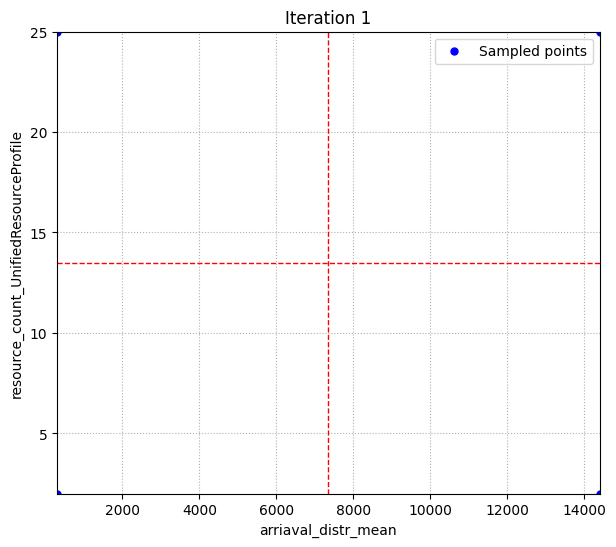



 # Evaluating corner at (300, 2)
  Target PPI List: [45348222.8, 44833491.8, 45126574.3, 45359684.1, 45235319.5, 45513323.8, 45481538.4, 45880569.1, 45455808.3, 45177243.5, 45246772.7, 45119428.8, 45379320.3, 45537526.1, 45684600.9, 45455341.0, 45281232.6, 44808288.6, 44887541.6, 45336741.7, 45321423.2, 45213255.6, 45639523.0, 45408950.8, 46030856.2, 45280688.7, 45342488.7, 45380770.3, 45843995.7, 44795542.7]
  In Target Range: False, Direction: above


 # Evaluating corner at (7350.0, 2)
  Target PPI List: [26359131.55, 25754567.7, 26158699.65, 26468437.95, 25937423.25, 26498242.3, 26006711.45, 26560615.6, 26137652.95, 25898778.95, 25459856.85, 26383593.65, 26297797.8, 26040734.25, 26008771.55, 26365165.95, 25601520.7, 25725872.95, 25969186.8, 26687016.95, 26504714.45, 26278695.05, 26363115.0, 26465539.75, 25624633.1, 25757146.35, 26383625.7, 26554617.95, 25581883.6, 25862385.65]
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 14)
  Target PPI List: [56668

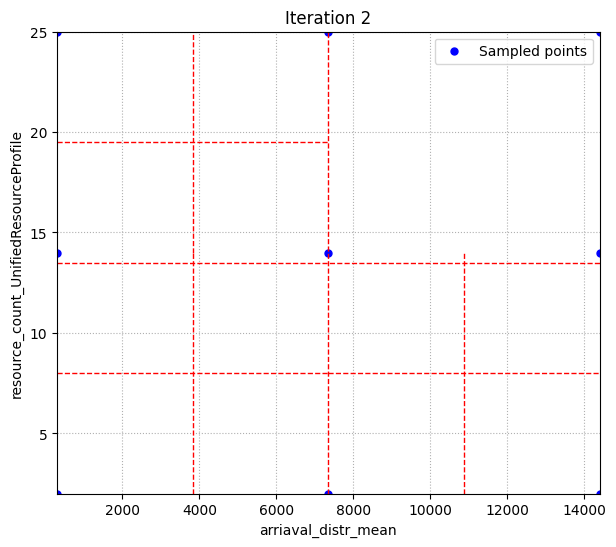



 # Evaluating corner at (300, 2)
  Target PPI List: [45348222.8, 44833491.8, 45126574.3, 45359684.1, 45235319.5, 45513323.8, 45481538.4, 45880569.1, 45455808.3, 45177243.5, 45246772.7, 45119428.8, 45379320.3, 45537526.1, 45684600.9, 45455341.0, 45281232.6, 44808288.6, 44887541.6, 45336741.7, 45321423.2, 45213255.6, 45639523.0, 45408950.8, 46030856.2, 45280688.7, 45342488.7, 45380770.3, 45843995.7, 44795542.7]
  In Target Range: False, Direction: above


 # Evaluating corner at (3825.0, 2)
  Target PPI List: [35576469.9, 35530690.4, 35237965.7, 35494247.6, 35290788.025, 35660204.3, 34987208.1, 35401833.4, 35142501.9, 35065035.8, 34855599.9, 35382200.0, 35335693.0, 35382161.1, 35394010.0, 35429233.9, 35554690.8, 35208565.6, 35361929.0, 34956807.8, 35772123.8, 35624232.1, 35333025.4, 34996686.1, 35659744.1, 35829642.2, 35524378.7, 35486299.0, 35259934.6, 35509664.1]
  In Target Range: False, Direction: above


 # Evaluating corner at (300, 8)
  Target PPI List: [10726369.9, 10654565.2, 

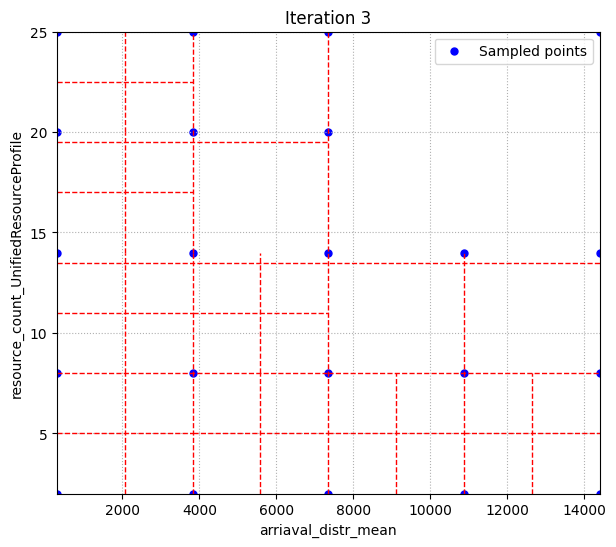



 # Evaluating corner at (300, 2)
  Target PPI List: [45348222.8, 44833491.8, 45126574.3, 45359684.1, 45235319.5, 45513323.8, 45481538.4, 45880569.1, 45455808.3, 45177243.5, 45246772.7, 45119428.8, 45379320.3, 45537526.1, 45684600.9, 45455341.0, 45281232.6, 44808288.6, 44887541.6, 45336741.7, 45321423.2, 45213255.6, 45639523.0, 45408950.8, 46030856.2, 45280688.7, 45342488.7, 45380770.3, 45843995.7, 44795542.7]
  In Target Range: False, Direction: above


 # Evaluating corner at (2062.5, 2)
  Target PPI List: [41181056.8875, 40145562.075, 40750400.9375, 40075199.65, 40582994.525, 40316885.475, 40590744.25, 40619255.15, 40166492.7875, 39970266.575, 39980537.4, 40363515.275, 40038215.0, 40453097.9, 39753400.1875, 39828168.025, 40769081.4875, 40481289.2, 40100688.7125, 40060753.4125, 40427074.6125, 40431196.725, 39930898.475, 40729279.1, 39908250.725, 40319750.7375, 40166760.3875, 40408787.8875, 40124389.35, 40149135.25]
  In Target Range: False, Direction: above


 # Evaluating corner at

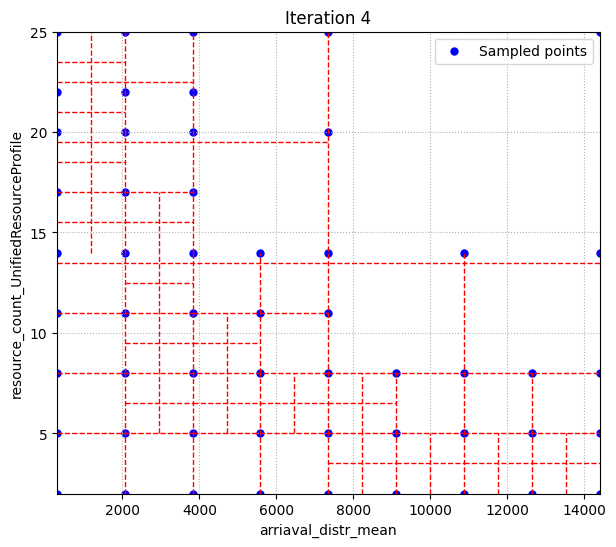



 # Evaluating corner at (2062.5, 5)
  Target PPI List: [12152292.1, 12215070.175, 12246382.525, 12068768.425, 12433333.975, 12131327.6875, 12232848.2125, 12103890.8, 12223662.9375, 12056578.0375, 12096558.3, 12351140.475, 12414929.4875, 12440367.5125, 12355450.5, 12212314.4375, 12266733.225, 12338181.425, 12331507.95, 12127576.4375, 12372943.4625, 12152658.575, 12355680.325, 12020331.9, 12293242.6, 12323131.1875, 12375632.4875, 12037851.65, 12420807.5, 12365614.0]
  In Target Range: False, Direction: above


 # Evaluating corner at (2943.75, 5)
  Target PPI List: [9986591.85625, 9885775.675, 10018438.45625, 10134014.20625, 10007330.5875, 10155057.05625, 10113814.6875, 9842356.66875, 10092551.09375, 10141765.15, 10020891.85625, 9942450.59375, 9881295.2625, 10021655.53125, 10078210.21875, 9913843.55, 10060751.34375, 10103304.66875, 10077974.04375, 9928461.375, 10131913.93125, 10076301.89375, 10008646.23125, 10063397.4125, 9991676.20625, 9955141.61875, 9980521.15625, 10193768.0, 9806520

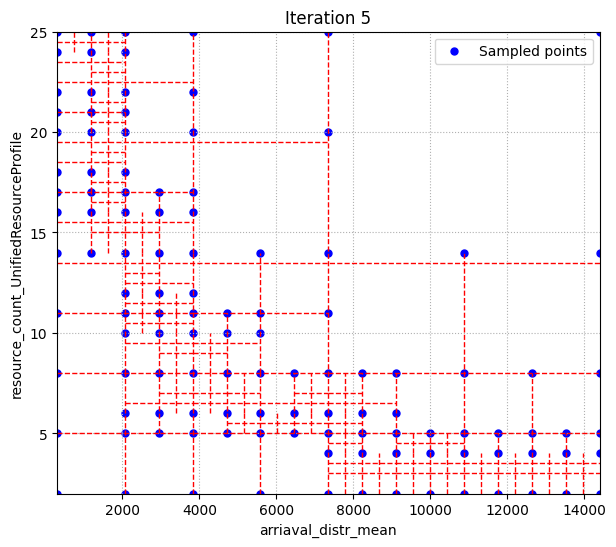



 # Evaluating corner at (2943.75, 6)
  Target PPI List: [7016799.0875, 7062283.38125, 6920692.25625, 7024803.26875, 6953923.31875, 6819029.60625, 6942899.61875, 6894619.975, 6867723.04375, 6932127.5625, 6754286.198698699, 6854399.45625, 6912797.85625, 6807347.70625, 6931021.35, 6911677.40625, 7000045.1375, 6760096.46875, 6896887.8875, 6752612.34375, 6861265.9, 6980203.2, 6719575.75625, 6790614.68125, 6704368.025, 6727233.81875, 6990105.38125, 6844976.65625, 6763000.025, 7006188.25]
  In Target Range: False, Direction: above


 # Evaluating corner at (3384.375, 6)
  Target PPI List: [5244677.725, 5038124.95625, 5306505.653125, 5093689.3875, 5199018.871875, 5074294.640625, 5068448.159375, 4975033.434375, 5116785.371875, 4938428.49375, 5247080.609375, 5043188.265625, 5245931.23125, 5044407.390625, 5283089.40625, 5047213.05, 5016529.315625, 5123955.8875, 5199769.328125, 5040451.025, 5106836.490625, 5180970.834375, 5262169.6875, 5309143.775, 5184021.775, 5166662.315625, 5138824.35, 518830

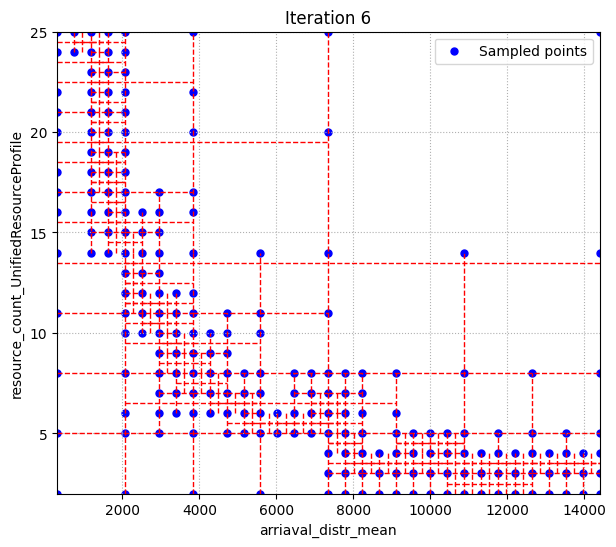



 # Evaluating corner at (3384.375, 7)
  Target PPI List: [2987257.821875, 2737290.003125, 2701467.290625, 2756938.0875, 2771910.5875, 2874389.996875, 2791692.984375, 2829924.303125, 2827888.775, 2761570.021875, 3050635.65625, 3017819.328125, 2876401.69375, 2757081.6973223225, 2832036.365625, 2748844.23485986, 2754822.665625, 3097696.54375, 2815067.346875, 2918835.965625, 2959342.271875, 2776142.5487987986, 2911934.978125, 2977638.2125, 2802763.3195695695, 2900658.5366616617, 2704284.684375, 2843290.740625, 2947168.4125, 2845553.612987988]
  In Target Range: False, Direction: above


 # Evaluating corner at (3604.6875, 7)
  Target PPI List: [1621751.8234375, 1680592.8748121243, 1585969.7765625, 1627258.34375, 1629689.811622367, 1558014.918043043, 1632215.2484375, 1753922.4630880882, 1542587.9035285285, 1641265.409159159, 1585722.4943693695, 1737355.3484375, 1519079.5015625, 1643733.8713713714, 1661815.0760135136, 1639908.9182932933, 1694553.0046875, 1606581.3031781781, 1630318.3109375

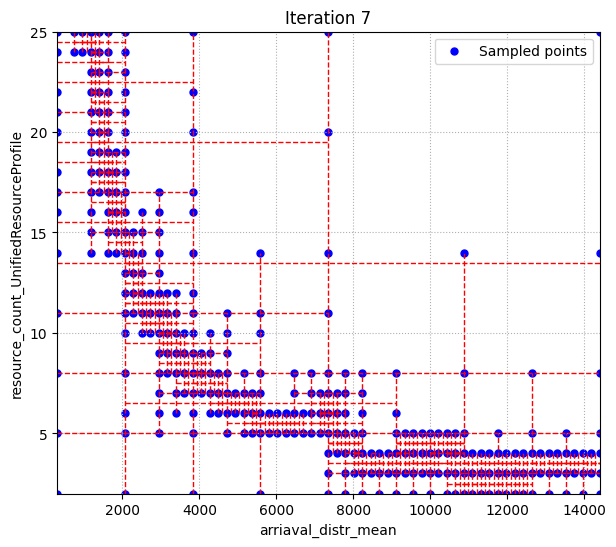

 Number of nodes: 1341, Number of sampled points: 317


In [580]:
# params['print_intermediate_results'] = True
# params['in_out_criteria'] = 'confidence'
# params['nr_simulations_per_scenario'] = 3
# params['cases_to_simulate'] = 1000
# params['target_ppi'] = 'cycle_time' #'idle_cycle_time'
# params['ppi_range_factor']: 0.2


if 'quadtree' in params['execute_strategy']:

    max_depth = params['strategies']['quadtree']['max_depth']

    # Reset the temp JSON file
    create_temp_json(input_path=params['json_path'], output_path=None)

    if __name__ == "__main__":

        # Run adaptive refinement
        frontier, quadtree_nodes, sampled_points, nodes_visited = adaptive_quadtree(
            set_sim_params_get_sim_stats,
            is_in_target_range, 
            params, 
            max_depth=max_depth)

    simulation_log.to_csv(params['simulation_log_path'], index=False)

In [581]:
params['target_range']

[22870.0, 42473.0]

In [582]:
print(simulation_log.head(5))

     algorithm simulation_id                    timestamp        target_range  \
0     orig_run             0  2025-10-27T21:29:41.079104Z  [22870.0, 42473.0]   
1  grid_search             1  2025-10-27T21:29:54.823325Z  [22870.0, 42473.0]   
2  grid_search             2  2025-10-27T21:30:08.279304Z  [22870.0, 42473.0]   
3  grid_search             3  2025-10-27T21:30:21.771201Z  [22870.0, 42473.0]   
4  grid_search             4  2025-10-27T21:30:35.310572Z  [22870.0, 42473.0]   

  status  target_ppi  target_ppi_mean  \
0   True  cycle_time     3.267173e+04   
1  False  cycle_time     4.535717e+07   
2  False  cycle_time     2.994241e+07   
3  False  cycle_time     2.226348e+07   
4  False  cycle_time     1.760814e+07   

                                     target_ppi_list  arriaval_distr_mean  \
0  [32379.47947947948, 33200.3003003003, 32792.48...               1800.0   
1  [45292426.6, 45420430.3, 44875584.0, 45547285....                300.0   
2  [30144529.2, 30008499.9, 2998417

In [583]:
params['strategies']

{'grid_search': {'granularity': 30, 'input': 'original_input'},
 'quadtree': {'max_depth': 7},
 'diagonal_search': {'stepsize_initial': 0.1,
  'step_max': 20,
  'adaptive_step': True,
  'strictness': 0.01},
 'hill_climbing': {'stepsize_initial': 0.1,
  'step_max': 20,
  'candidate_strategy': 'random_one',
  'walk_reps_max': 100}}

In [584]:
params['strategies']['quadtree']['paths'] = {}
params['strategies']['quadtree']['paths']['sampled_points'] = os.path.join(params['experiment_output_dir'], 'quadtree_sampled_points.csv')
params['strategies']['quadtree']['paths']['nodes_visited'] = os.path.join(params['experiment_output_dir'], 'quadtree_nodes_visited.csv')


In [585]:
import csv

def write_quadtree_nodes_to_file(quadtree_nodes, params):
    """
    Write the quadtree nodes to a CSV file.

    Args:
        quadtree_nodes (list[QuadNode]): List of quadtree nodes.
        params (dict): Simulation pipeline parameters containing output file path.
    Returns:
        None
    """
    output_file_path = params['strategies']['quadtree']['paths']['sampled_points']

    # Define the header for the CSV file
    header = ["x_min", "x_max", "y_min", "y_max", "depth", "is_leaf", "status"]

    # Open the file for writing
    with open(output_file_path, mode="w", newline="") as file:
        writer = csv.DictWriter(file, fieldnames=header)
        
        # Write the header
        writer.writeheader()
        
        # Write each node's properties
        for node in quadtree_nodes:
            writer.writerow({
                "x_min": node.x_min,
                "x_max": node.x_max,
                "y_min": node.y_min,
                "y_max": node.y_max,
                "depth": node.depth,
                "is_leaf": node.is_leaf,
                "status": node.status,
            })

    print(f"Quadtree nodes written to {output_file_path}")

In [586]:
import json

def write_nodes_visited_to_json(nodes_visited, params):
    """
    Write the nodes_visited dictionary to a JSON file.

    Args:
        nodes_visited (dict): Dictionary containing nodes visited and sampled points at each depth level.
        output_file (str): Path to the output JSON file.

    Returns:
        None
    """
    output_file = params['strategies']['quadtree']['paths']['nodes_visited']
    with open(output_file, "w") as file:
        json.dump(nodes_visited, file, indent=4)  # Use indent=4 for pretty formatting
    print(f"Nodes visited written to {output_file}")

In [587]:

def read_quadtree_nodes_from_file(input_file):
    """
    Read quadtree nodes from a CSV file and return them as a list of QuadNode objects.

    Args:
        input_file (str): Path to the input CSV file.

    Returns:
        list[QuadNode]: List of QuadNode objects.
    """
    quadtree_nodes = []

    # Open the file for reading
    with open(input_file, mode="r") as file:
        reader = csv.DictReader(file)
        
        # Read each row and create a QuadNode object
        for row in reader:
            quadtree_nodes.append(
                QuadNode(
                    x_min=float(row["x_min"]),
                    x_max=float(row["x_max"]),
                    y_min=float(row["y_min"]),
                    y_max=float(row["y_max"]),
                    depth=int(row["depth"]),
                    is_leaf=row["is_leaf"] == "True",  # Convert string to boolean
                    status=row["status"],
                )
            )

    print(f"Quadtree nodes read from {input_file}")
    return quadtree_nodes

In [588]:
def read_nodes_visited_from_json(input_file):
    """
    Read the nodes_visited data from a JSON file and return it as a dictionary.

    Args:
        input_file (str): Path to the input JSON file.

    Returns:
        dict: Dictionary containing nodes visited and sampled points at each depth level.
    """
    with open(input_file, "r") as file:
        nodes_visited = json.load(file)
    print(f"Nodes visited read from {input_file}")
    return nodes_visited

In [589]:
write_quadtree_nodes_to_file(quadtree_nodes, params)
write_nodes_visited_to_json(nodes_visited, params)

Quadtree nodes written to data/LoanApp_SingleRole_fixDuration/output/20251027_222928/quadtree_sampled_points.csv
Nodes visited written to data/LoanApp_SingleRole_fixDuration/output/20251027_222928/quadtree_nodes_visited.csv


## 3. Evaluation


###### Second try

In [590]:
import numpy as np
import pandas as pd

def evaluate_quadtree_vs_simulation_log(all_nodes, simulation_log, params, depth_level):
    """
    Evaluate how many ground-truth grid points (from simulation_log) fall inside
    in_range vs out_range quadtree nodes, up to a given depth level.
    Also reports how many grid points remain unclassified (not covered by any
    in_range or out_range node), and how many nodes were visited and computed.

    Parameters
    ----------
    all_nodes : list[QuadNode]
        All nodes from the quadtree. Each node must have: 
        x_min, x_max, y_min, y_max, depth, is_leaf, status.
    simulation_log : pd.DataFrame
        DataFrame containing at least:
            - param_x, param_y : grid search coordinates
            - status : True (in-range) or False (out-of-range)
    params : dict
        Contains 'params_to_change' with two parameters being varied.
    depth_level : int
        Only consider quadtree nodes up to this depth.

    Returns
    -------
    results_df : pd.DataFrame
        Per-node statistics.
    summary : pd.Series
        Aggregated counts including number of unclassified grid points,
        nodes visited, and nodes computed.
    """

    # Determine which parameter names correspond to X and Y
    param_x, param_y = list(params['params_to_change'].keys())

    # Keep only grid search entries
    simulation_log = simulation_log[simulation_log['algorithm'] == 'grid_search'].copy()

    # Extract numpy arrays for faster computation
    grid_x = simulation_log[param_x].to_numpy()
    grid_y = simulation_log[param_y].to_numpy()
    grid_status = simulation_log['status'].astype(bool).to_numpy()
    total_points = len(simulation_log)

    counted_indices = set()
    results = []

    # Initialize counters for visited and computed nodes
    nodes_visited = 0
    nodes_computed = 0

    for node in all_nodes:
        # Count the node as visited if it is within the depth level
        if node.depth <= depth_level:
            nodes_visited += 1

        # Only process leaf nodes up to target depth
        if not node.is_leaf or node.depth > depth_level:
            continue

        # Count the node as computed if it is a leaf node at the depth level
        nodes_computed += 1

        if node.status not in ("in_range", "out_range"):
            # Skip mixed or undefined nodes when classifying points
            continue

        x_min, x_max, y_min, y_max = node.x_min, node.x_max, node.y_min, node.y_max

        # Identify points inside this node
        inside_mask = (
            (grid_x >= x_min) &
            (grid_x <= x_max) &
            (grid_y >= y_min) &
            (grid_y <= y_max)
        )
        inside_indices = np.where(inside_mask)[0]

        # Remove duplicates (points already counted)
        new_indices = [i for i in inside_indices if i not in counted_indices]
        counted_indices.update(new_indices)
        new_indices = np.array(new_indices)

        # Count how many are True vs False in the ground truth
        if len(new_indices) > 0:
            in_true = np.sum(grid_status[new_indices])
            out_true = len(new_indices) - in_true
        else:
            in_true = out_true = 0

        results.append({
            "depth": node.depth,
            "status": node.status,
            "x_min": x_min,
            "x_max": x_max,
            "y_min": y_min,
            "y_max": y_max,
            "n_points_total": len(new_indices),
            "n_points_true_inrange": in_true,
            "n_points_true_outrange": out_true,
        })

    results_df = pd.DataFrame(results)

    # ---- Aggregate summary ----
    total_in_nodes = np.sum(results_df["status"] == "in_range")
    total_out_nodes = np.sum(results_df["status"] == "out_range")

    points_in_inrange_nodes = int(results_df.loc[results_df["status"] == "in_range", "n_points_total"].sum())
    points_in_outrange_nodes = int(results_df.loc[results_df["status"] == "out_range", "n_points_total"].sum())

    unique_points_classified = len(counted_indices)
    unclassified_points = total_points - unique_points_classified

    # Get the unclassified points
    unclassified_indices = [i for i in range(total_points) if i not in counted_indices]
    unclassified_points_df = simulation_log.iloc[unclassified_indices][[param_x, param_y]]


    summary = {
        "depth_level": depth_level,
        "total_nodes": len(results_df),
        "in_range_nodes": total_in_nodes,
        "out_range_nodes": total_out_nodes,
        "points_in_inrange_nodes": points_in_inrange_nodes,
        "points_in_outrange_nodes": points_in_outrange_nodes,
        "unique_points_classified": unique_points_classified,
        "unclassified_points": unclassified_points,
        "fraction_inrange_nodes_points": (
            results_df.loc[results_df["status"] == "in_range", "n_points_true_inrange"].sum() / total_points
            if total_points > 0 else 0
        ),
        "fraction_outrange_nodes_points": (
            results_df.loc[results_df["status"] == "out_range", "n_points_true_outrange"].sum() / total_points
            if total_points > 0 else 0
        ),
        "fraction_unclassified_points": (
            unclassified_points / total_points if total_points > 0 else 0
        ),
        "nodes_visited": nodes_visited,  # Total nodes visited at this depth
        "nodes_computed": nodes_computed,  # Total nodes computed at this depth
    }

    # display(unclassified_points_df)

    return results_df, pd.Series(summary)

In [591]:
import pandas as pd
import numpy as np

def compute_quadtree_metrics(results_df, summary):
    """
    Compute precision, recall, and accuracy for quadtree classification
    against the ground truth (simulation_log), based on output from
    `evaluate_quadtree_vs_simulation_log`.

    Parameters
    ----------
    results_df : pd.DataFrame
        Output DataFrame from evaluate_quadtree_vs_simulation_log, containing:
          - status (in_range / out_range)
          - n_points_true_inrange
          - n_points_true_outrange
    summary : pd.Series
        Summary output including total_points or unclassified counts.

    Returns
    -------
    pd.Series
        Metrics including precision, recall, accuracy, and unclassified fraction.
    """

    # --- Count confusion matrix elements ---
    TP = results_df.loc[results_df["status"] == "in_range", "n_points_true_inrange"].sum()
    FP = results_df.loc[results_df["status"] == "in_range", "n_points_true_outrange"].sum()
    TN = results_df.loc[results_df["status"] == "out_range", "n_points_true_outrange"].sum()
    FN = results_df.loc[results_df["status"] == "out_range", "n_points_true_inrange"].sum()

    total_classified = TP + FP + TN + FN
    total_points = summary.get("unique_points_classified", total_classified) + summary.get("unclassified_points", 0)

    # --- Metrics ---
    precision = TP / (TP + FP) if (TP + FP) > 0 else np.nan
    recall = TP / (TP + FN) if (TP + FN) > 0 else np.nan
    accuracy = (TP + TN) / total_classified if total_classified > 0 else np.nan
    mcc = (
        (TP * TN - FP * FN) /
        np.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))
        if (TP + FP) > 0 and (TP + FN) > 0 and (TN + FP) > 0 and (TN + FN) > 0 else np.nan
    )

    unclassified_fraction = (
        summary.get("unclassified_points", 0) / total_points if total_points > 0 else np.nan
    )

    return pd.Series({
        "TP": int(TP),
        "FP": int(FP),
        "TN": int(TN),
        "FN": int(FN),
        "precision_inrange": precision,
        "recall_inrange": recall,
        "accuracy": accuracy,
        "mcc": mcc,
        "unclassified_fraction": unclassified_fraction,
        "total_points": int(total_points),
        "classified_points": int(total_classified),
        "unclassified_points": int(summary.get("unclassified_points", 0)),
    })


In [592]:
# Assuming your simulation_log DataFrame has 'param_x' and 'param_y'
results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth_level=7)

print(summary)

# Optional: inspect detailed per-node results
display(results_df.head(10))

depth_level                          7.000000
total_nodes                        254.000000
in_range_nodes                     131.000000
out_range_nodes                    123.000000
points_in_inrange_nodes            523.000000
points_in_outrange_nodes           176.000000
unique_points_classified           699.000000
unclassified_points                 21.000000
fraction_inrange_nodes_points        0.725000
fraction_outrange_nodes_points       0.241667
fraction_unclassified_points         0.029167
nodes_visited                     1341.000000
nodes_computed                    1006.000000
dtype: float64


,depth,status,x_min,x_max,y_min,y_max,n_points_total,n_points_true_inrange,n_points_true_outrange
0,1,in_range,7350.0,14400.0,14,25,180,180,0
1,2,in_range,7350.0,10875.0,8,14,42,42,0
2,2,in_range,10875.0,14400.0,8,14,48,48,0
3,2,in_range,3825.0,7350.0,14,20,49,49,0
4,2,in_range,3825.0,7350.0,20,25,35,35,0
5,3,out_range,300.0,2062.5,2,5,16,0,16
6,3,out_range,2062.5,3825.0,2,5,16,0,16
7,3,out_range,300.0,2062.5,5,8,12,0,12
8,3,out_range,3825.0,5587.5,2,5,12,0,12
9,3,out_range,5587.5,7350.0,2,5,16,2,14


In [593]:
results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth_level=5)
metrics = compute_quadtree_metrics(results_df, summary)
print(metrics)


TP                       517.000000
FP                         1.000000
TN                       158.000000
FN                         2.000000
precision_inrange          0.998069
recall_inrange             0.996146
accuracy                   0.995575
mcc                        0.987711
unclassified_fraction      0.058333
total_points             720.000000
classified_points        678.000000
unclassified_points       42.000000
dtype: float64


In [594]:
def plot_quadtree_metrics_over_depth(quadtree_nodes, simulation_log, params, max_depth, metric="accuracy"):
    """
    Plots quadtree metrics (accuracy, precision, or recall) and the fraction of classified points
    over the depth levels of the quadtree.

    Args:
        all_nodes (list[QuadNode]): All nodes from the quadtree.
        simulation_log (pd.DataFrame): DataFrame containing ground-truth grid points.
        params (dict): Contains 'params_to_change' with two parameters being varied.
        max_depth (int): Maximum depth level to evaluate.
        metric (str): The metric to plot on the left y-axis. Options: "accuracy", "precision", "recall".

    Returns:
        None
    """
    # Initialize lists to store metrics for each depth level
    depths = []
    metric_values = []
    fractions_classified = []

    # Map the metric argument to the correct key in the metrics object
    metric_key_map = {
        "accuracy": "accuracy",
        "mcc": "mcc",
        "precision": "precision_inrange",
        "recall": "recall_inrange"
    }
    if metric not in metric_key_map:
        raise ValueError("Invalid metric. Choose from 'accuracy', 'precision', or 'recall'.")

    metric_key = metric_key_map[metric]

    # Iterate over depth levels
    for depth in range(1, max_depth + 1):
        # Evaluate the quadtree at the current depth level
        results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth)

        # Compute metrics for the current depth level
        metrics = compute_quadtree_metrics(results_df, summary)

        # Append depth and metrics
        depths.append(depth)
        metric_values.append(metrics[metric_key])  # Use the correct key for the selected metric
        fractions_classified.append(1 - metrics["unclassified_fraction"])  # Fraction classified

    # Plot the metrics
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the selected metric on the left y-axis
    ax1.set_xlabel("Tree Depth Level")
    ax1.set_ylabel(metric.capitalize(), color="tab:blue")
    ax1.plot(depths, metric_values, label=metric.capitalize(), color="tab:blue", marker="o")
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Plot the fraction of classified points on the right y-axis
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 1)
    ax2.set_ylabel("Fraction of Classified Points", color="tab:orange")
    ax2.plot(depths, fractions_classified, label="Fraction Classified", color="tab:orange", marker="x")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    # Add a title and legend
    fig.suptitle(f"Quadtree Metrics vs Depth (Metric: {metric.capitalize()})", fontsize=14)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    # Show the plot
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.savefig(os.path.join(params['experiment_output_dir'], f'quadtree_{metric}_vs_depth.png'))
    plt.show()

In [595]:
simulation_log.head(2)

,algorithm,simulation_id,timestamp,target_range,status,target_ppi,target_ppi_mean,target_ppi_list,arriaval_distr_mean,resource_count_UnifiedResourceProfile
0,orig_run,0,2025-10-27T21:29:41.079104Z,"[22870.0, 42473.0]",True,cycle_time,3.267173e+04,"[32379.47947947948, 33200.3003003003, 32792.48...",1800.0,19
1,grid_search,1,2025-10-27T21:29:54.823325Z,"[22870.0, 42473.0]",False,cycle_time,4.535717e+07,"[45292426.6, 45420430.3, 44875584.0, 45547285....",300.0,2


In [596]:
import matplotlib.pyplot as plt

def generate_and_plot_quadtree_metrics(quadtree_nodes, simulation_log, params, max_depth, nodes_visited):
    """
    Generate quadtree metrics for each depth level and plot the required metrics.

    Args:
        quadtree_nodes (list[QuadNode]): All nodes from the quadtree.
        simulation_log (pd.DataFrame): DataFrame containing grid search points.
        params (dict): Contains 'params_to_change' with two parameters being varied.
        max_depth (int): Maximum depth level to evaluate.
        nodes_visited (dict): Dictionary containing the number of nodes visited and evaluated at each depth.

    Returns:
        None
    """
    # Initialize lists to store metrics
    quadtree_metrics = []

    # Generate metrics for each depth level
    for depth in range(1, max_depth + 1):
        # depth += 1
        results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth)
        metrics = compute_quadtree_metrics(results_df, summary)
        quadtree_metrics.append(metrics)

    # Extract depth levels from nodes_visited
    # depth_levels = list(nodes_visited.keys())

    depth_levels = [d for d in range(1, max_depth + 1)]

    # Extract metrics for plotting
    grid_search_points = len(simulation_log[simulation_log['algorithm'] == 'grid_search'])  # Total number of grid search points (horizontal line)
    classified_points = [
        metrics["classified_points"] for metrics in quadtree_metrics
    ]  # Absolute number of classified points
    all_nodes_visited = [nodes_visited[depth-1]["all_nodeds"] for depth in depth_levels]  # All nodes visited
    sampled_points =    [nodes_visited[depth-1]["sampled_points"] for depth in depth_levels]  # Evaluated points

    # Plot the metrics
    plt.figure(figsize=(10, 6))

    # Horizontal line for grid search points
    plt.axhline(y=grid_search_points, color="tab:blue", linestyle="--", label="Grid Search Points (Total)")

    # Absolute number of classified points
    plt.plot(
        depth_levels,
        classified_points,
        label="Classified Points",
        color="tab:orange",
        marker="o",
    )

    # # All nodes visited
    # plt.plot(
    #     depth_levels,
    #     all_nodes_visited,
    #     label="All Nodes Visited",
    #     color="tab:green",
    #     marker="s",
    # )

    # Evaluated points
    plt.plot(
        depth_levels,
        sampled_points,
        label="Evaluated Points",
        color="tab:red",
        marker="x",
    )

    # Add labels, legend, and title
    plt.xlabel("Tree Depth Level", fontsize=12)
    plt.ylabel("Number of Parameter Settings", fontsize=12)
    plt.title("Quadtree Evaluation Metrics vs Tree Depth Level", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)

    plt.savefig(os.path.join(params['experiment_output_dir'], 'quadtree_evaluation_metrics.png'))

    # Show the plot
    plt.show()

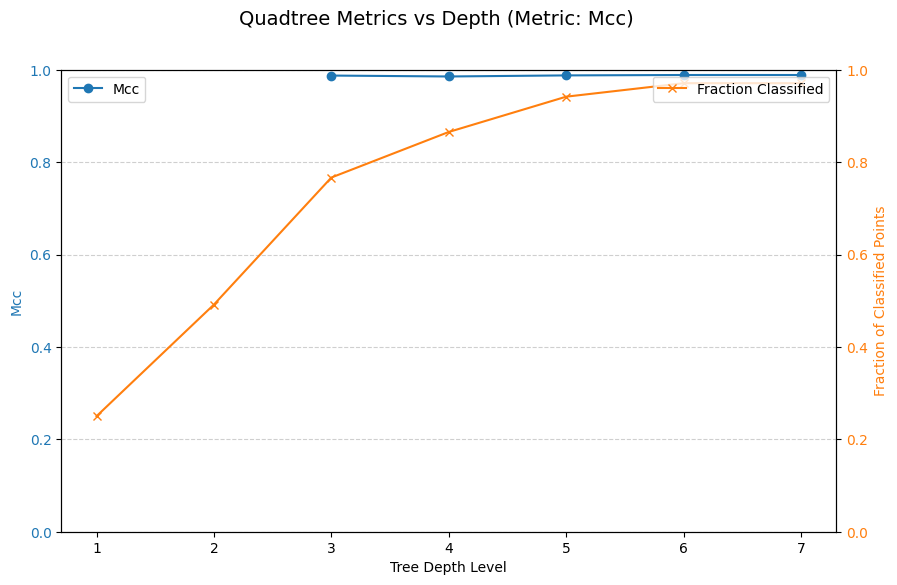

In [597]:
#  Call the function
plot_quadtree_metrics_over_depth(quadtree_nodes, simulation_log, params, max_depth=7, metric="mcc")

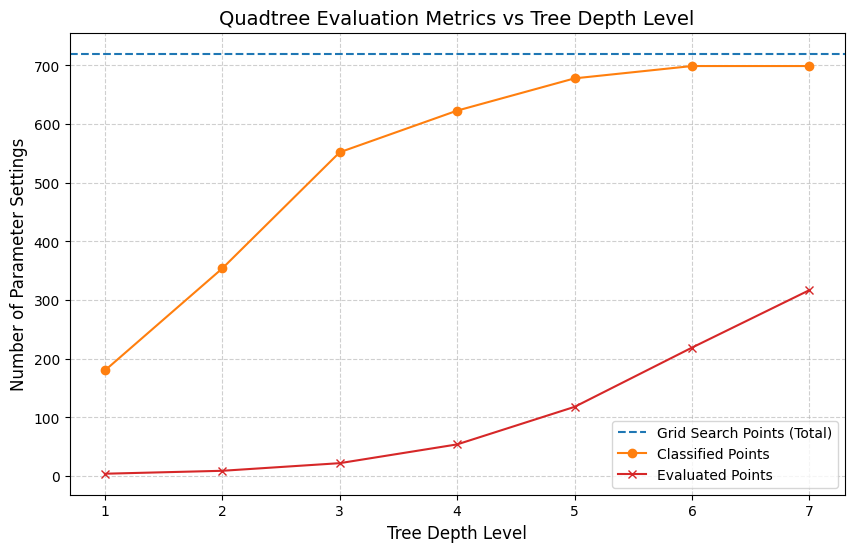

In [598]:
# Call the function
generate_and_plot_quadtree_metrics(quadtree_nodes, simulation_log, params, max_depth=7, nodes_visited=nodes_visited)

###### Testing

In [489]:
# frontier, quadtree_nodes, sampled_points
for node in quadtree_nodes[:10]:
    # print(node.x_min, node.x_max, node.y_min, node.y_max, getattr(node, "in_range", False))
    if getattr(node, "in_range", True):
        print(node.x_min, node.x_max, node.y_min, node.y_max, node.depth, len(node.children), node.is_leaf, node.status)#, node.corner_results)
        # print(node)

300 14400 2 25 0 4 False mixed
300 7350.0 2 14 1 4 False mixed
7350.0 14400 2 14 1 4 False mixed
300 7350.0 14 25 1 4 False mixed
7350.0 14400 14 25 1 0 True in_range
300 3825.0 2 8 2 0 True out_range
3825.0 7350.0 2 8 2 4 False mixed
300 3825.0 8 14 2 4 False mixed
3825.0 7350.0 8 14 2 4 False mixed
7350.0 10875.0 2 8 2 4 False mixed


In [490]:

### Test

# display simulation log filtered for grid search runs
display(simulation_log[simulation_log['algorithm'] == 'grid_search'].head(5))

# set the status of this point to False
# 18	grid_search	18	2025-10-27T09:33:42.395579Z	[53841.0, 80762.0]	True	idle_cycle_time	67473.913645	[66621.54710605, 67106.30869354002, 68693.8851...	10875.0	13
# simulation_log.loc[18, 'status'] = False

# Assuming your simulation_log DataFrame has 'param_x' and 'param_y'
results_df, summary = evaluate_quadtree_vs_simulation_log(quadtree_nodes, simulation_log, params, depth_level=2)

print(summary)

# Optional: inspect detailed per-node results
display(results_df.head(10))


,algorithm,simulation_id,timestamp,target_range,status,target_ppi,target_ppi_mean,target_ppi_list,arriaval_distr_mean,resource_count_UnifiedResourceProfile
1,grid_search,1,2025-10-27T17:35:11.414963Z,"[22812.0, 42365.0]",False,cycle_time,45484885.31,"[45709289.7, 45539943.1, 45311977.9, 45637918....",300.0,2
2,grid_search,2,2025-10-27T17:35:15.560210Z,"[22812.0, 42365.0]",False,cycle_time,30070278.91,"[29706055.1, 29907719.4, 30201039.6, 30073923....",300.0,3
3,grid_search,3,2025-10-27T17:35:19.670300Z,"[22812.0, 42365.0]",False,cycle_time,22344496.00,"[22324351.5, 22364060.1, 22478546.8, 22550449....",300.0,4
4,grid_search,4,2025-10-27T17:35:23.845178Z,"[22812.0, 42365.0]",False,cycle_time,17617291.47,"[17884107.5, 17383016.8, 17695751.3, 17708993....",300.0,5
5,grid_search,5,2025-10-27T17:35:27.951988Z,"[22812.0, 42365.0]",False,cycle_time,14498390.49,"[14344271.9, 14422731.9, 14539471.9, 14426673....",300.0,6


depth_level                         2.000000
total_nodes                         6.000000
in_range_nodes                      5.000000
out_range_nodes                     1.000000
points_in_inrange_nodes           354.000000
points_in_outrange_nodes           56.000000
unique_points_classified          410.000000
unclassified_points               310.000000
fraction_inrange_nodes_points       0.491667
fraction_outrange_nodes_points      0.077778
fraction_unclassified_points        0.430556
nodes_visited                      17.000000
nodes_computed                      6.000000
dtype: float64


,depth,status,x_min,x_max,y_min,y_max,n_points_total,n_points_true_inrange,n_points_true_outrange
0,1,in_range,7350.0,14400.0,14,25,180,180,0
1,2,out_range,300.0,3825.0,2,8,56,0,56
2,2,in_range,7350.0,10875.0,8,14,42,42,0
3,2,in_range,10875.0,14400.0,8,14,48,48,0
4,2,in_range,3825.0,7350.0,14,20,49,49,0
5,2,in_range,3825.0,7350.0,20,25,35,35,0


### Old works

**Simulation Input: Parameters**

- \( x_1, x_2, x_3 \)

**Simulation Output:**

- \( y = f(x_1, x_2, x_3) \)

**Goal:** 

- Find \( x \) such that \( y_{\text{low}} \leq f(x) \leq y_{\text{high}} \)


<strong>Simulation Input: Parameters</strong>

<ul>
  <li>x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub></li>
</ul>

<strong>Simulation Output:</strong>

<ul>
  <li>y = f(x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>)</li>
</ul>

<strong>Goal:</strong>

<ul>
  <li>Find x such that y<sup>low</sup> &le; f(x) &le; y<sup>high</sup></li>
</ul>

#### External Library

In [1273]:
# %pip install scipy

In [1274]:
from scipy.optimize import brentq
import numpy as np

def is_ppi_within_target(ppi, target_range):
    return target_range[0] <= ppi <= target_range[1]

def make_ppi_constraint_function(simulate_func, target_range):
    """Returns a function that is negative inside safe zone and positive outside."""
    def constraint_func(x):
        ppi = simulate_func(x)
        # print(f"Testing {x} → PPI: {ppi}")
        if is_ppi_within_target(ppi, target_range):
            return -1  # safe
        else:
            return 1   # unsafe
    return constraint_func

def find_safe_bounds_brentq(simulate_func, baseline_value, domain_min, domain_max, target_range):
    constraint_func = make_ppi_constraint_function(simulate_func, target_range)
    bounds = [baseline_value, baseline_value]

    # Search upper bound
    try:
        upper = brentq(constraint_func, baseline_value, domain_max)
        bounds[1] = upper
    except ValueError:
        # No crossing → assume safe until domain_max
        bounds[1] = domain_max

    # Search lower bound
    try:
        lower = brentq(constraint_func, domain_min, baseline_value)
        bounds[0] = lower
    except ValueError:
        # No crossing → assume safe until domain_min
        bounds[0] = domain_min

    return bounds


In [1275]:
def run_simulation_with_param(param_value):
    # A fake PPI function (in practice this calls your simulation engine)
    # Assume PPI gets worse (higher) as param_value increases
    return 3.0 + 0.002 * (param_value - 3600)


In [1276]:
baseline = 3600
domain_min = 3000
domain_max = 5000
target_range = [0, 5]  # PPI must be ≤ 5

safe_bounds = find_safe_bounds_brentq(get_simulation_stats,
                                       baseline,
                                       domain_min,
                                       domain_max,
                                       target_range)

print(f"Safe bounds for param: {safe_bounds} seconds")
print(f"Safe bounds in hours: [{safe_bounds[0]/3600:.2f}, {safe_bounds[1]/3600:.2f}] hrs")


AttributeError: 'float' object has no attribute 'get'

### 3. Semi-factual statements

Output:
- For all involved simulation parameters that can be changed:
    - Show tha Maximum range it can be changed from all the possible found solutions
    - In an interactive fashion, the user can choose to change a first parameter and based on that change, all other parameter changes in their range
